In [1]:
import os
from deepface import DeepFace
from deepface.modules import verification
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
from collections import Counter
import tensorflow as tf
import cv2
import pandas as pd

2025-07-24 18:24:39.158449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 18:24:41.658703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 18:24:41.661547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 18:24:48.988089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
PATH = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/screenshots/'

In [3]:
def test_detector_backends(detectors, list_patients, indx, PATH):
    dict_undetected = {}
    for detector in detectors:
        print("Testing",detector,"...")
        num_undetected = 0
        for p in list_patients:
            for n in indx: 
                try:
                    image_path = PATH+p+"_"+n+".png"
                    detect = DeepFace.extract_faces(image_path, enforce_detection=True,detector_backend=detector)
                    # facial_area = detect[0]['facial_area']
                    # confidence = detect[0]['confidence']
    
                   
                except Exception as e:
                    num_undetected +=1
        dict_undetected[detector] = num_undetected
    return dict_undetected
            

In [4]:
def get_facial_embeddings(PATH,list_all, indx = ['1','2','A'],model='Facenet512',detector='retinaface'):
    emb_dict = {}
    for p in list_all:
        # print(p)
        emb_dict[p] = {}
        for n in indx:
            try:
                emb_dict[p][n] = DeepFace.represent(img_path = PATH+p+"_"+n+".png", enforce_detection=True,detector_backend=detector,model_name=model) 
            except:
                print(p,n,": No face detected")
                emb_dict[p][n] = DeepFace.represent(img_path = PATH+p+"_"+n+".png", enforce_detection=False,detector_backend=detector,model_name=model) 
                
    
    return emb_dict

In [5]:
def get_same_distances_dict(emb_dict, a, b, distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    for p in [p for p in list(emb_dict.keys()) if p not in skip]:
        print(p)
        v_a = emb_dict[p][a][0]['embedding']
        v_b = emb_dict[p][b][0]['embedding']
        # to do -- change 0 to be taken before
        dist =  verification.find_distance(v_a, v_b, distance_metric)
        dist_dict[p] = dist
        dist_list.append(dist)

    return dist_dict,dist_list

def get_diff_distances_dict(emb_dict,distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    list_to_do = [p for p in list(emb_dict.keys()) if p not in skip]
    for p1 in [p for p in list(emb_dict.keys()) if p not in skip] :
        list_to_do.remove(p1)
        dist_dict[p1] = {}
        for p2 in list_to_do:            

            v_a = emb_dict[p1]['1'][0]['embedding']
            v_b = emb_dict[p2]['1'][0]['embedding']
            # to do -- change 0 to be taken before
            
            dist = verification.find_distance(v_a, v_b, distance_metric)
          
            dist_dict[p1][p2] = dist
            dist_list.append(dist)
        
    return dist_dict, dist_list


In [6]:
def plot_hist(same, diff,density=True,threshold=0.4):
    fig, ax1 = plt.subplots()
    
    # Plot histogram for 'Same Patient'
    color = 'blue'
    ax1.set_xlabel('Cosine Distance')
    ax1.set_ylabel('# of image pairs (Same Patient)', color=color)
    ax1.hist(same, bins=15, alpha=0.5, label='Same Patient', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

  
    
    # Create a second y-axis for 'Different Patient'
    ax2 = ax1.twinx()  
    color = 'red'
    ax2.set_ylabel('# of image pairs (Different Patient)', color=color)
    ax2.hist(diff, bins=30, alpha=0.5, label='Different Patient', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.axvline(x=threshold, color='gray', linestyle='--',label='Threshold')
    
    # Add legend and show plot
    fig.tight_layout()
    fig.legend(loc='center right', bbox_to_anchor=(0.85, 0.85))
    
    plt.show()

In [7]:
def plot_two_whiskers(same,diff,threshold=0.4): 
    data = [same, diff]
    plt.rcParams['font.size'] = 12.
    fig = plt.figure(figsize=(5,5)) 
    ax = fig.add_axes([0,0,1,1]) 
    bp = ax.boxplot(data,patch_artist=True)#, vert=True, patch_artist=True, notch=True, bootstrap=5)
    colors = ['blue', 'red'] 
    for patch, color in zip(bp['boxes'], colors): 
        patch.set_facecolor(color)
    
    for whisker in bp['whiskers']: 
        whisker.set(color ='#8B008B', linewidth = 1.5, linestyle =":") 
    # Changing color and line width of caps 
    for cap in bp['caps']: 
        cap.set(color ='black', linewidth = 2) 
        
    ax.axhline(y=threshold, color='gray', linestyle='--',label='Threshold') 
    ax.set_xticklabels(['CT1-CT2','CT1 to other patient']) 
    plt.ylabel("Cosine Similarity") 
    ax.set_ylim(ymin=0)
    handles, labels = ax.get_legend_handles_labels() 
    custom_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in colors] 
    custom_labels = ['Same Patient', 'Different Patient'] 
    fig.legend(custom_patches + handles, custom_labels + labels, loc='upper left', bbox_to_anchor=(0.2, 0.95)) 
    fig.tight_layout() # show plot plt.show()

In [8]:
def plot_two_whiskers_with_connections(same, anon,diff=[], threshold=0.4):
    if len(diff) == 0:
        data = [same,anon]
        fig = plt.figure(figsize=(5, 5))
    else:
        data = [same, anon,diff]
        fig = plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 16.
    
    # Create a figure instance
    
    
    # Create an axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Create the boxplot
    bp = ax.boxplot(data, patch_artist=True)
    
    # Set colors for boxplots
    if len(diff)==0:
        # colors=['#332288','#44AA99']
        colors=['blue','red']
    else:
        # colors = ['#332288','#44AA99', '#AA4499']
        colors = ['blue','#44AA99','red']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Changing color and line width of whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#8B008B', linewidth=1.5, linestyle=":")
    
    # Changing color and line width of caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=2)
    
    # Add individual points and connect them with lines
    x_positions = [1, 2]  # Positions of the boxplots
    for i, (s, d) in enumerate(zip(same, anon)):
        ax.scatter([x_positions[0]], [s], color='navy', s=5,zorder=3)
        ax.scatter([x_positions[1]], [d], color='#194039', s=5,zorder=3)
        ax.plot(x_positions, [s, d], color='lightblue', alpha=0.6, linestyle='-', zorder=2)

    # x_positions = [1, 2]  # Positions of the boxplots
    # for i, (s) in enumerate(diff):
    #     ax.scatter([3], [s], color='maroon', s=5,zorder=3)
    
    # Add threshold line
    ax.axhline(y=threshold, color='gray', linestyle='--', label='Threshold')
    
    # Add labels and formatting
    if len(diff) == 0:
        ax.set_xticklabels(['CT1 to CT2', 'CT1 to other patient'])
    else:
        ax.set_xticklabels(['$CT_{t1}$ vs $CT_{t2}$', '$dCT_{t1}$ vs $CT_{t2}$','$CT_{t1,patient\ i}$ \nvs $CT_{t1, patient\ j}$'])
    plt.ylabel("Cosine Distance")
    ax.set_ylim(ymin=0)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    custom_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
    
    if len(diff) != 0:
        custom_labels = ['Same Patient', 'Defaced Patient','Different Patient']
    else:
        custom_labels = ['Same Patient', 'Different Patient']
    fig.legend(custom_patches + handles, custom_labels + labels, loc='upper right', bbox_to_anchor=(1.7, 0.95))
    fig.tight_layout()
    
    # Show plot
    plt.show()


In [9]:
def get_optimal_threshold(list_same, list_diff):
    data = np.concatenate([list_same, list_diff])
    labels = np.concatenate([np.zeros(len(list_same)), np.ones(len(list_diff))])
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(labels, data)
    
    # Find the optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"The optimal threshold is: {optimal_threshold}")
    return optimal_threshold

In [10]:
def plot_3_x3(same_list,diff_list,anon_list,names=['Cosine Distance','Euclidean Distance','Euclidean L2 Distance'],threshold=0.4):
    plt.rcParams['font.size'] = 14.
  
    if len(same_list) > 1:
        fig, axes = plt.subplots(1, len(same_list), figsize=(15, 5))  # 1 row, 3 columns
    else:
        fig = plt.figure(figsize=(5,5))
        # Create an axes instance
        ax = fig.add_axes([0,0,1,1])

    for i in range(len(same_list)):
        if len(same_list)> 1:
            ax = axes[i]
        # Create the boxplot
        data = [same_list[i], diff_list[i], anon_list[i]]
        bp = ax.boxplot(data, patch_artist=True)
        
        colors = ['blue', 'red','yellow']
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        # Changing color and line width of whiskers
        for whisker in bp['whiskers']:
            whisker.set(color='#8B008B', linewidth=1.5, linestyle=":")

        # Changing color and line width of caps
        for cap in bp['caps']:
            cap.set(color='black', linewidth=2)
        
        ax.set_xticklabels(['CT1-CT2', 'CT1 to \n other patient','CT2 - \nAnon CT1'])
        ax.set_ylabel(names[i])
        ax.set_ylim(ymin=0)

        ax.axhline(y=threshold, color='green', linestyle='--', linewidth=2)
    
    plt.show()

In [11]:
def plot_hist_x3x3(same, diff, anon, names=['Cosine Distance', 'Euclidean Distance', 'Euclidean L2 Distance'], density=False, threshold=0.4):
    plt.rcParams['font.size'] = 16.
  
    num_plots = len(same)  # Number of subplots
    if num_plots > 1:
        fig, axes = plt.subplots(1, num_plots, figsize=(15, 5))  # 1 row, `num_plots` columns
    else:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        axes = [ax]  # Make `axes` iterable for consistency

    # Determine common bin edges across all data
    all_data = np.concatenate([np.array(same).flatten(), np.array(diff).flatten(), np.array(anon).flatten()])
    bins = np.linspace(np.min(all_data), np.max(all_data), 30)

    for i in range(num_plots):
        ax1 = axes[i] if num_plots > 1 else axes[0]
        ax2 = ax1.twinx()

        # Use colorblind-friendly colors
        same_color = 'blue'
        diff_color = 'red'
        anon_color = 'turquoise'

        # Plot `diff` on the LEFT axis (after swapping)
        ax1.hist(diff[i], bins=bins, alpha=0.8, density=False, label='Different Patient', color=diff_color)
        ax1.set_ylabel('# of image pairs (Different Patient)', color=diff_color)
        ax1.tick_params(axis='y', labelcolor=diff_color)

        # Plot `same` and `anon` on the RIGHT axis (after swapping)
        ax2.hist(same[i], bins=bins, alpha=0.8, density=False, label='Same Patient', color=same_color)
        if len(anon) > i:
            ax2.hist(anon[i], bins=bins, alpha=0.8, density=False, label='Anon Patient', color=anon_color)
        ax2.set_ylabel('# of image pairs (Same & Defaced)', color=same_color)
        ax2.axvline(x=threshold, color='gray', linestyle='--', linewidth=2, label='Threshold')
        ax2.tick_params(axis='y', labelcolor=same_color)

        # Properly set x-axis label
        ax1.set_xlabel(names[i])

    # Combine legends and position outside the plot
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2, loc='center right', bbox_to_anchor=(1.7, 0.5))  # Legend outside

    fig.tight_layout()
    plt.show()


In [12]:
def get_same_distances_dict(emb_dict, a, b, distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    for p in [p for p in list(emb_dict.keys()) if p not in skip]:
        v_a = emb_dict[p][a][0]['embedding']
        v_b = emb_dict[p][b][0]['embedding']
        # to do -- change 0 to be taken before
        dist =  verification.find_distance(v_a, v_b, distance_metric)
        dist_dict[p] = dist
        dist_list.append(dist)

    return dist_dict,dist_list

def get_diff_distances_dict(emb_dict,distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    list_to_do = [p for p in list(emb_dict.keys()) if p not in skip]
    for p1 in [p for p in list(emb_dict.keys()) if p not in skip] :
        list_to_do.remove(p1)
        dist_dict[p1] = {}
        for p2 in list_to_do:            

            v_a = emb_dict[p1]['1'][0]['embedding']
            v_b = emb_dict[p2]['1'][0]['embedding']
            # to do -- change 0 to be taken before
            
            dist = verification.find_distance(v_a, v_b, distance_metric)
          
            dist_dict[p1][p2] = dist
            dist_list.append(dist)
        
    return dist_dict, dist_list


In [13]:
backends = ['opencv', 'ssd', 'dlib',  'mtcnn', 'fastmtcnn','retinaface', 'mediapipe','yolov8','yunet', 'centerface']
models = [ "VGG-Face",  "Facenet",   "Facenet512",  "OpenFace",   "DeepFace", "DeepID",  "ArcFace",  "Dlib", "SFace", "GhostFaceNet",]
metrics = ["cosine", "euclidean", "euclidean_l2"]

In [14]:
# get list patients: 
list_all = []
for f in [x.split("_")[0] for x in os.listdir(PATH) if "_1" in x]:
    list_all.append(f)
list_all.sort(key = int)
print(len(list_all))

78


## Determine best detector backend

In [14]:
skip = []

In [15]:
test_detector_backends(backends, list_all,['1','2'],PATH)

Testing opencv ...
Testing ssd ...
24-11-27 15:59:02 - res10_300x300_ssd_iter_140000.caffemodel will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
To: /home/kayla/.deepface/weights/res10_300x300_ssd_iter_140000.caffemodel
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.7M/10.7M [00:00<00:00, 96.1MB/s]


Testing dlib ...
24-11-27 15:59:14 - shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded


Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /home/kayla/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.71M/5.71M [00:00<00:00, 9.51MB/s]


Testing mtcnn ...
Testing fastmtcnn ...
Testing retinaface ...
Testing mediapipe ...
Testing yolov8 ...
Testing yunet ...
Testing centerface ...


{'opencv': 10,
 'ssd': 60,
 'dlib': 5,
 'mtcnn': 156,
 'fastmtcnn': 156,
 'retinaface': 1,
 'mediapipe': 156,
 'yolov8': 156,
 'yunet': 82,
 'centerface': 51}

##### Conclusion: Retinaface is the best for our dataset

In [16]:
# skip = ['638']

In [17]:
# def get_facial_embeddings(PATH,list_all, indx = ['1','2','A'],model='Facenet512',detector='retinaface'):
#     emb_dict = {}
#     for p in list_all:
#         # print(p)
#         emb_dict[p] = {}
#         for n in indx:
#             try:
#                 emb_dict[p][n] = DeepFace.represent(img_path = PATH+p+"_"+n+".png", enforce_detection=True,detector_backend=detector,model_name=model) 
#             except:
#                 print(p,n,": No face detected")
    
#     return emb_dict

In [332]:
emb_dict_all_models = {}
for model in models:
    print(model)
    emb_dict_all_models[model] = get_facial_embeddings(PATH,[p for p in list_all if p not in skip],indx=['1','2'],model=model)
    

VGG-Face
19 1 : No face detected
19 2 : No face detected
54 1 : No face detected
54 2 : No face detected
59 1 : No face detected
59 2 : No face detected
70 1 : No face detected
70 2 : No face detected
81 1 : No face detected
81 2 : No face detected
118 1 : No face detected
118 2 : No face detected
272 1 : No face detected
272 2 : No face detected
274 1 : No face detected
274 2 : No face detected
437 1 : No face detected
437 2 : No face detected
447 1 : No face detected
447 2 : No face detected
448 1 : No face detected
448 2 : No face detected
452 1 : No face detected
452 2 : No face detected
454 1 : No face detected
454 2 : No face detected
459 1 : No face detected
459 2 : No face detected
462 1 : No face detected
462 2 : No face detected
467 1 : No face detected
467 2 : No face detected
469 1 : No face detected
469 2 : No face detected
473 1 : No face detected
473 2 : No face detected
474 1 : No face detected
474 2 : No face detected
478 1 : No face detected
478 2 : No face detected
4

In [8]:
emb_dict_all_models.keys()

dict_keys(['VGG-Face', 'Facenet', 'Facenet512', 'OpenFace', 'DeepFace', 'DeepID', 'ArcFace', 'Dlib', 'SFace', 'GhostFaceNet'])

In [15]:
undetected = ['638','35']
skip = undetected +  ['70','452','467','908','1763','1955','964']
skip = skip + ['1552'] #+ ['1167']
# skip = skip + ['447','469','1552'] + ['644','738'],'1167'

In [304]:
full_results_same = {}
full_diff_results = {}

for model in emb_dict_all_models: 
    if model != 'DeepFace':
        _,full_results_same[model] =  get_same_distances_dict(emb_dict_all_models[model], '1', '2', 'cosine',skip=skip)
        _,full_diff_results[model] =  get_diff_distances_dict(emb_dict_all_models[model],'cosine',skip=skip)

In [305]:
full_results_same_l2 = {}
full_diff_results_l2 = {}

for model in emb_dict_all_models: 
    if model != 'DeepFace':
        _,full_results_same_l2[model] =  get_same_distances_dict(emb_dict_all_models[model], '1', '2', 'euclidean_l2',skip=skip)
        _,full_diff_results_l2[model] =  get_diff_distances_dict(emb_dict_all_models[model],'euclidean_l2',skip=skip)

full_results_same_euc = {}
full_diff_results_euc = {}

for model in emb_dict_all_models: 
    if model != 'DeepFace':
        _,full_results_same_euc[model] =  get_same_distances_dict(emb_dict_all_models[model], '1', '2', 'euclidean',skip=skip)
        _,full_diff_results_euc[model] =  get_diff_distances_dict(emb_dict_all_models[model],'euclidean',skip=skip)

In [306]:
# full_results_same

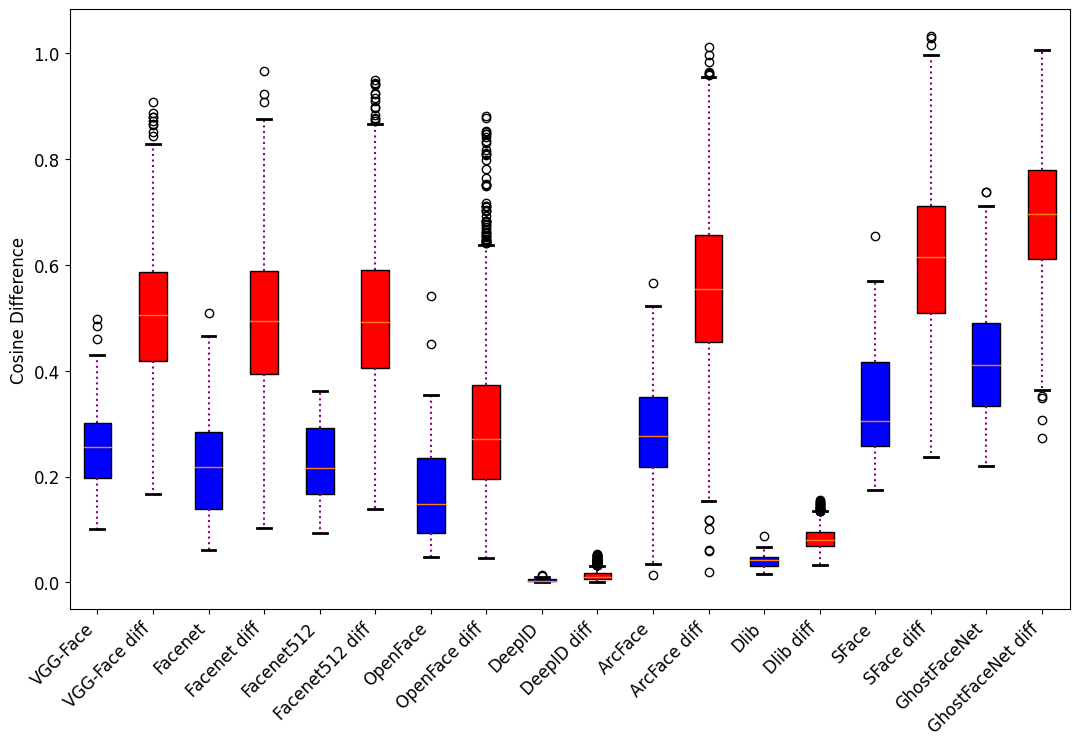

In [307]:
plot_results_model(full_results_same, full_diff_results)
# plot_results_model(full_results_same_euc, full_diff_results_euc)
# plot_results_model(full_results_same_l2, full_diff_results_l2)

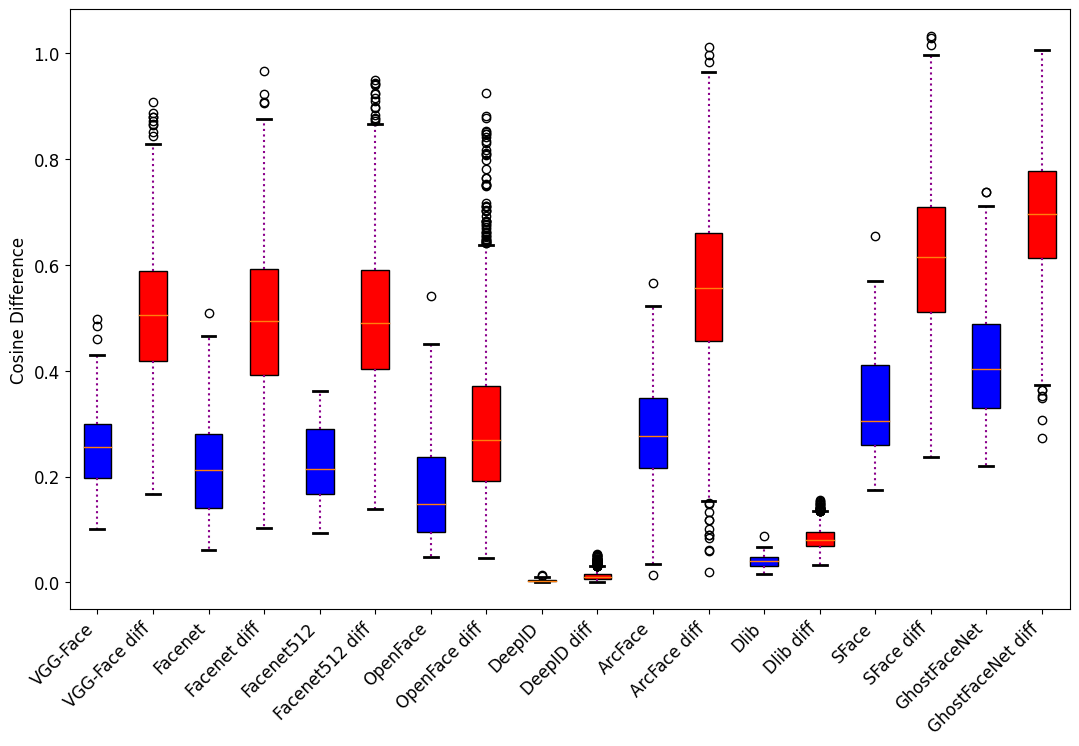

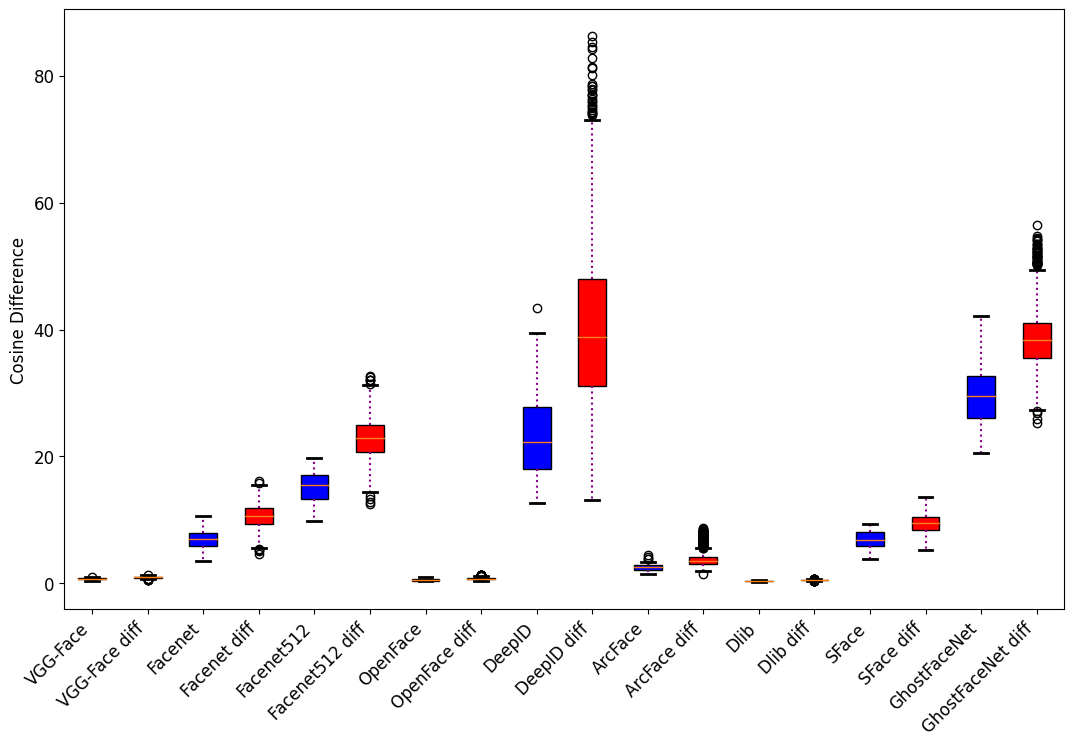

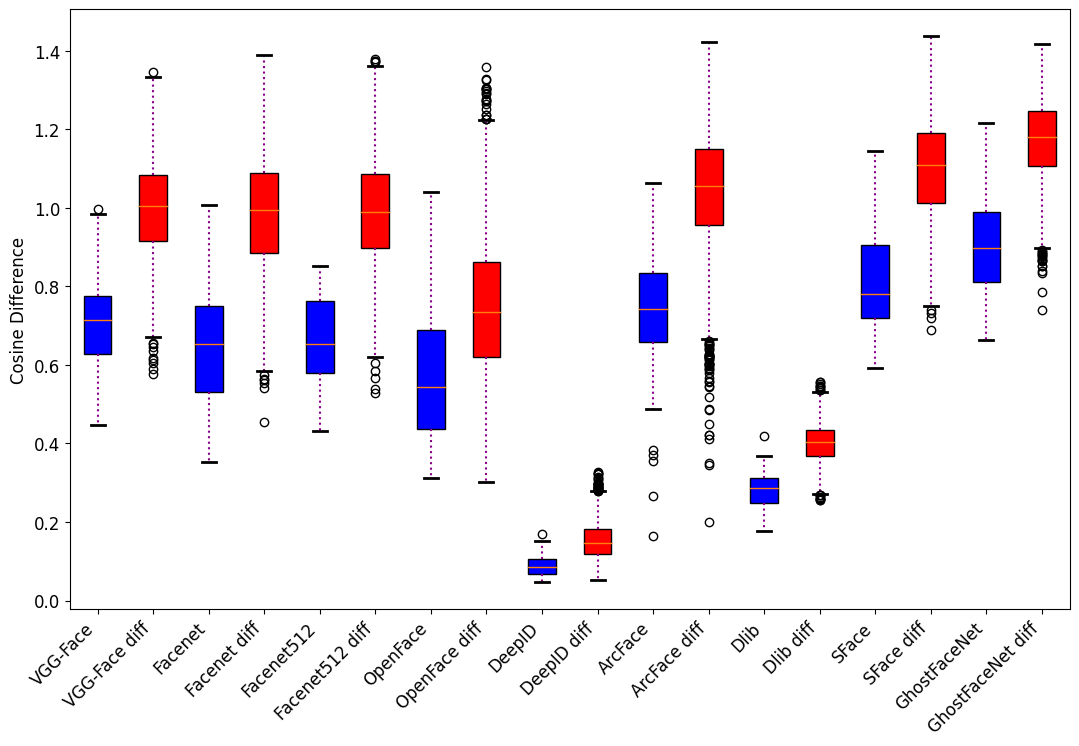

In [55]:
plot_results_model(full_results_same, full_diff_results)
plot_results_model(full_results_same_euc, full_diff_results_euc)
plot_results_model(full_results_same_l2, full_diff_results_l2)

### Setting a threshold

In [43]:
undetected = ['638']

In [16]:
emb_dict = get_facial_embeddings(PATH,[p for p in list_all if p not in undetected],indx=['1','2','A'],model='Facenet512')

2025-07-24 18:25:34.000604: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15556608 exceeds 10% of free system memory.
2025-07-24 18:25:34.854420: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15556608 exceeds 10% of free system memory.
2025-07-24 18:25:35.385800: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15556608 exceeds 10% of free system memory.
2025-07-24 18:25:35.406509: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15721920 exceeds 10% of free system memory.
2025-07-24 18:25:35.412418: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82968576 exceeds 10% of free system memory.


478 A : No face detected
633 A : No face detected
694 A : No face detected
964 A : No face detected
1892 A : No face detected
2037 A : No face detected


In [48]:
p='35'
num=['1','2','A']
emb_dict[p] = {}
for n in num:
    emb_dict[p][n] = DeepFace.represent(img_path = PATH+p+"_"+n+".png", enforce_detection=False,detector_backend='retinaface',model_name='Facenet512')

In [49]:
skip =['638','70','452','467','908','964','1763','1955']

In [50]:
print([p for p in list_all if p not in skip])

['19', '35', '54', '59', '81', '118', '272', '274', '437', '447', '448', '454', '459', '462', '469', '473', '474', '478', '483', '517', '518', '600', '625', '628', '633', '644', '651', '662', '673', '685', '694', '721', '723', '734', '738', '755', '770', '773', '786', '790', '820', '833', '838', '848', '892', '910', '937', '945', '946', '961', '965', '973', '1167', '1255', '1288', '1314', '1502', '1511', '1552', '1888', '1892', '1949', '1987', '2017', '2027', '2037', '2041', '2056', '2058', '2061']


In [51]:
len([p for p in list_all if p not in skip])

70

In [52]:

for p in [p for p in list_all if p not in skip]:
    if p not in emb_dict:
        print(p)

# skip

In [21]:
same_dict, same_list =  get_same_distances_dict(emb_dict, '1', '2', 'cosine',skip=skip)
diff_dict, diff_list =  get_diff_distances_dict(emb_dict,'cosine',skip=skip)
anon_dict, anon_list =  get_same_distances_dict(emb_dict, 'A', '2', 'cosine',skip=skip)

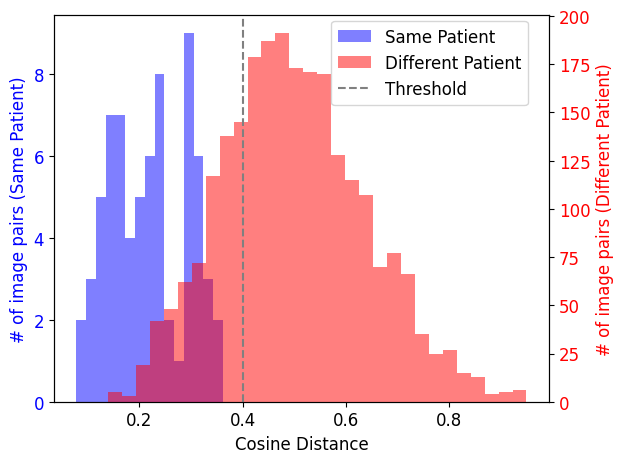

In [56]:
plot_hist(same_list,diff_list,density=True)

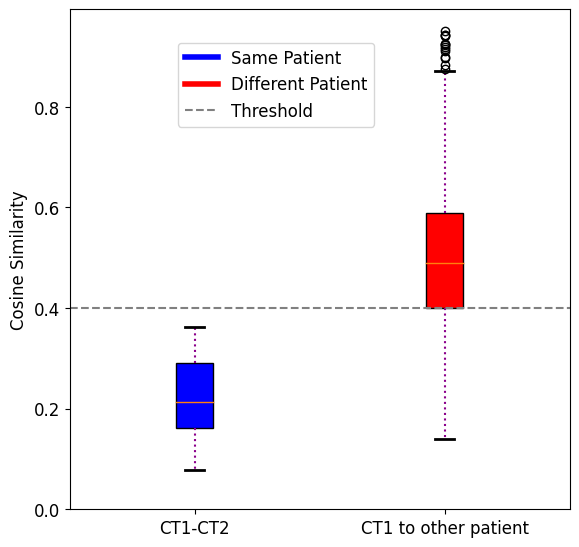

In [36]:
plot_two_whiskers(same_list,diff_list)

In [57]:
len(same_dict)

70

In [159]:
from chefboost import Chefboost as chef
config = {'algorithm': 'C4.5'}
tmp_df = df[['distance', 'decision']].rename(columns = {"decision": "Decision"}).copy()
model = chef.fit(tmp_df, config)

ModuleNotFoundError: No module named 'chefboost'

In [ ]:
tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
tp_std = round(df[df.decision == "Yes"].std().values[0], 4)
fp_mean = round(df[df.decision == "No"].mean().values[0], 4)
fp_std = round(df[df.decision == "No"].std().values[0], 4)

In [23]:
optimal_threshold = get_optimal_threshold(same_list,diff_list)

The optimal threshold is: 0.3310264075361308


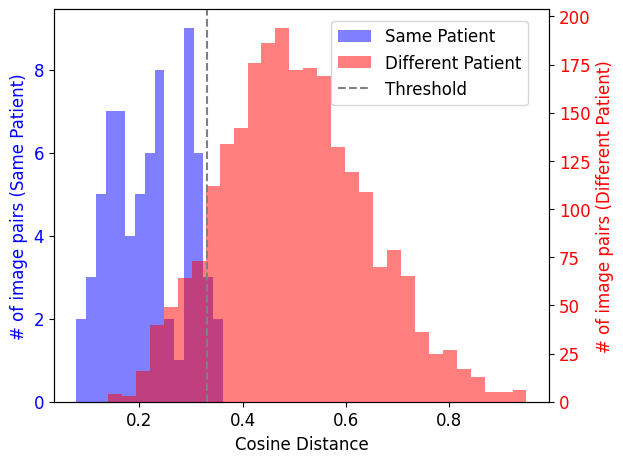

In [36]:
plot_hist(same_list,diff_list,density=True,threshold=optimal_threshold)

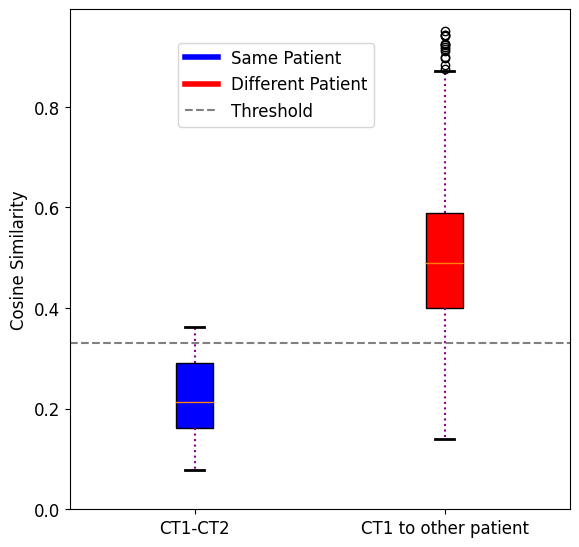

In [23]:
plot_two_whiskers(same_list,diff_list,threshold=optimal_threshold)

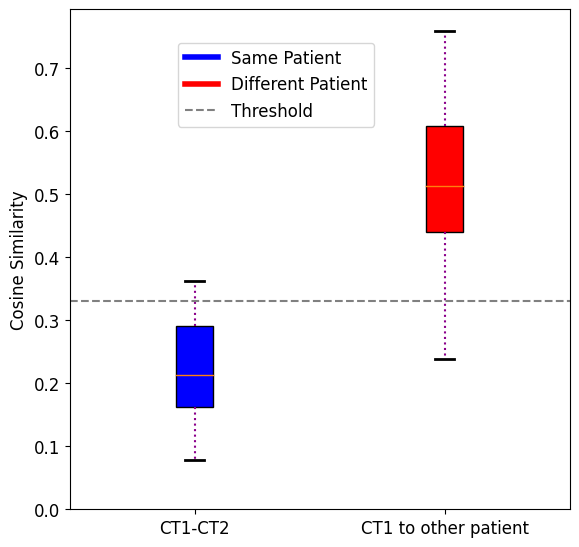

In [69]:
plot_two_whiskers(same_list,anon_list,threshold=optimal_threshold)

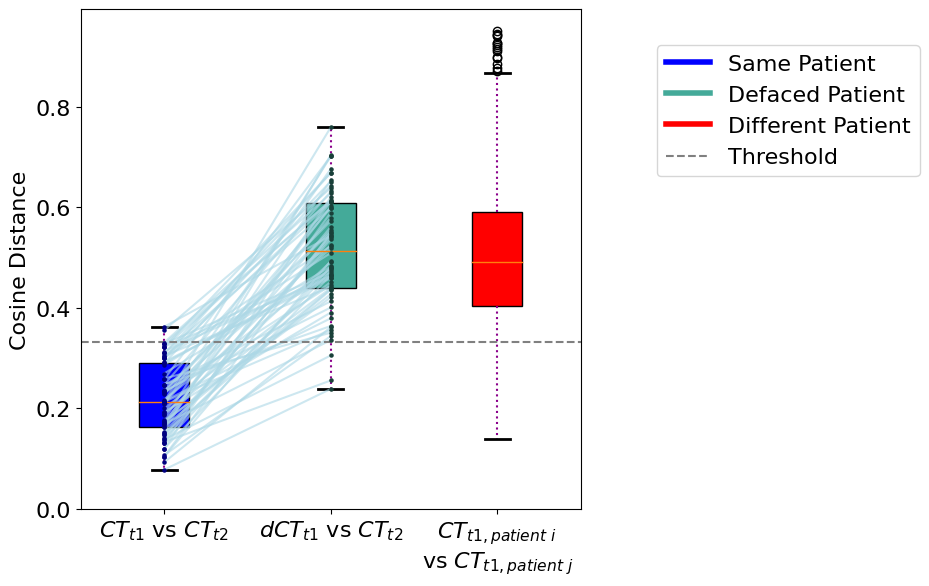

In [210]:
plot_two_whiskers_with_connections(same_list,anon_list,diff_list,threshold=optimal_threshold)

In [110]:
len(diff_list)

2415

In [86]:
undetected

['638']

In [96]:
num_matches_s = 0
num_total_s = 0
for p in same_dict.keys():
    num_total_s+=1
    if same_dict[p] < optimal_threshold:
        num_matches_s+=1
    if same_dict[p] > optimal_threshold:
        print(p, same_dict[p])

54 0.3553012077712828
2027 0.36222532177554234


In [94]:
# skip = skip +  ['70','452','467','908','1763','1955','964','1167']
# skip = skip + ['1552']

In [156]:
print("Same patient matches:",num_matches_s, "/", num_total_s,"=",num_matches_s/num_total_s)

Same patient matches: 68 / 70 = 0.9714285714285714


In [98]:
num_matches_a = 0
num_total_a = 0
for p in anon_dict.keys():
    num_total_a+=1
    if anon_dict[p] < optimal_threshold:
        num_matches_a+=1
        print(p, anon_dict[p])

274 0.305320297265928
838 0.2555946552797079
1167 0.2387253969176445


In [157]:
print("Anon patient matches:",num_matches_a, "/", num_total_a,"=",num_matches_a/num_total_a)

Anon patient matches: 3 / 70 = 0.04285714285714286


In [90]:
list_below = []
num_matches = 0
num_total = 0
for p1 in diff_dict.keys():
    for p2 in diff_dict[p1]:
        num_total += 1
        if diff_dict[p1][p2] < optimal_threshold:
            print(p1, p2, diff_dict[p1][p2])
            list_below.append(p1)
            list_below.append(p2)
            num_matches+=1

19 59 0.2775491012394914
19 81 0.3289197367703025
19 447 0.25018885280922243
19 454 0.2561258998374921
19 462 0.31404393463184
19 469 0.21979985754476572
19 473 0.31369347165604944
19 483 0.1394715028446032
19 600 0.32258190406416487
19 651 0.3249325630514288
19 734 0.2943726043846008
19 770 0.2881017106171301
19 1511 0.32864977631643233
19 2058 0.28320554956032207
59 447 0.2685700795114022
59 469 0.26592621607450584
59 755 0.29343589009728843
59 770 0.22924631372065485
59 945 0.32348685862501647
59 1255 0.24045927971774506
59 1888 0.29060216885343515
81 118 0.20947598442875393
81 437 0.26421788138932123
81 447 0.2939837315133699
81 454 0.29692673033074746
81 469 0.22835989441753113
81 770 0.2703511832283214
81 1255 0.28777397328755927
81 2027 0.2513594759744404
118 437 0.25715742073725345
118 447 0.25091617231059204
118 448 0.24610020881824612
118 454 0.29195990359855206
118 469 0.21223404208020014
118 892 0.3277230901366226
118 965 0.32262724670802756
118 1255 0.22106478791785167
118

In [158]:
print("False positive matches:",num_matches, "/", num_total,"=",num_matches/num_total)

False positive matches: 258 / 2415 = 0.10683229813664596


In [92]:
len(list_all) - len(skip)


70

In [108]:
count_dict = dict(Counter(list_below))
dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))

{'1552': 23,
 '447': 19,
 '892': 19,
 '738': 19,
 '1888': 17,
 '673': 16,
 '469': 15,
 '2058': 15,
 '19': 13,
 '644': 13,
 '1288': 13,
 '651': 11,
 '118': 11,
 '1511': 11,
 '685': 11,
 '946': 11,
 '694': 11,
 '473': 10,
 '755': 10,
 '945': 10,
 '1255': 10,
 '965': 10,
 '2061': 10,
 '81': 9,
 '483': 9,
 '59': 8,
 '454': 8,
 '770': 8,
 '1167': 8,
 '600': 7,
 '517': 7,
 '1987': 7,
 '973': 7,
 '628': 7,
 '721': 7,
 '1949': 7,
 '1892': 7,
 '2041': 6,
 '833': 6,
 '1314': 6,
 '838': 6,
 '734': 5,
 '2056': 5,
 '790': 5,
 '773': 5,
 '274': 4,
 '662': 4,
 '848': 4,
 '478': 4,
 '937': 4,
 '462': 3,
 '35': 3,
 '2027': 3,
 '272': 3,
 '625': 3,
 '786': 3,
 '2017': 2,
 '437': 2,
 '448': 2,
 '459': 2,
 '723': 2,
 '820': 2,
 '910': 1,
 '474': 1,
 '2037': 1,
 '961': 1}

In [109]:
list_A = []
for f in [x.split("_")[0] for x in os.listdir(PATH) if "_A" in x]:
    list_A.append(f)
list_A.sort(key = int)
# print(len(list_all))

list_todo = []
for p in list_all:
    if p  not in list_A and p not in skip:
        list_todo.append(p)
        

In [110]:
list_todo

[]

### Anonymization

In [111]:
# emb_dict = get_facial_embeddings(PATH,[p for p in list_all if p not in undetected],indx=['1','2','A'],model='Facenet512')

In [112]:
# anon_dict, anon_list =  get_same_distances_dict(emb_dict, 'A', '2', 'cosine',skip=skip)

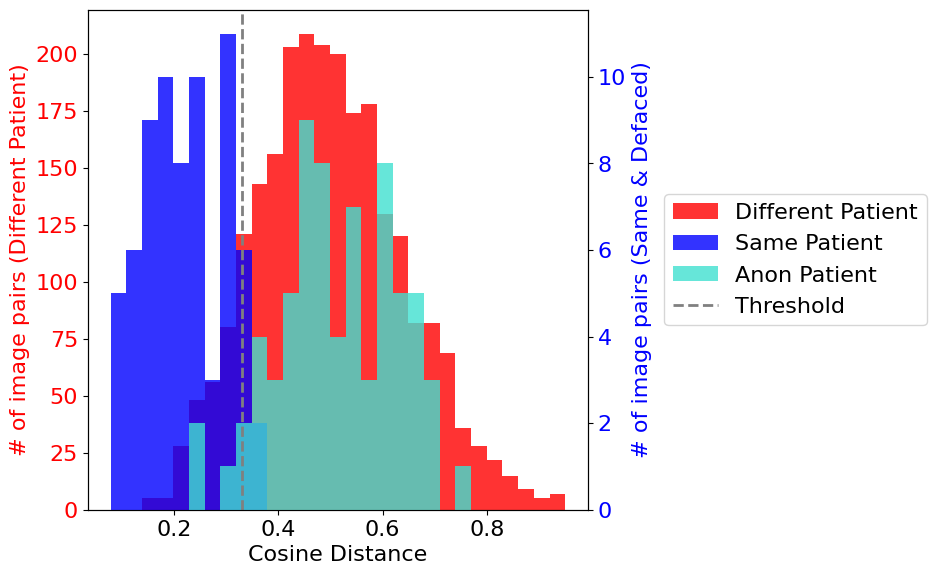

In [200]:
plot_hist_x3x3([same_list], [diff_list],[anon_list],threshold=optimal_threshold,density=True)

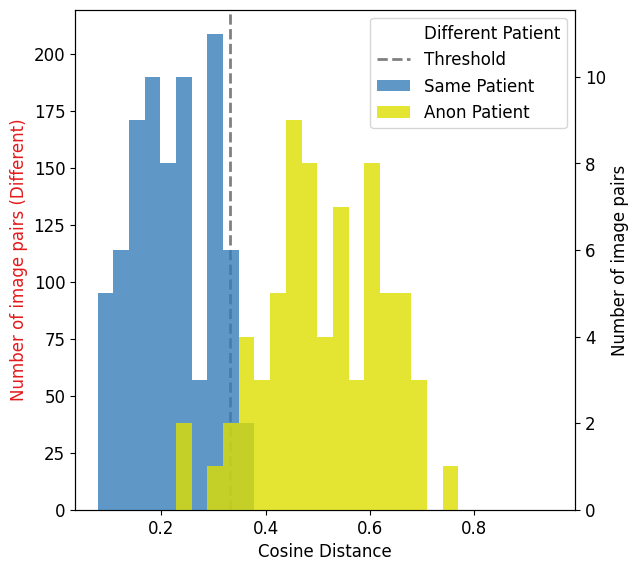

In [66]:
plot_hist_x3x3([same_list], [diff_list],[anon_list],threshold=optimal_threshold)

In [17]:
df_clin = pd.read_csv('/data/kayla/df_sex_clin.csv')

In [18]:
F_emb_dict = {}
M_emb_dict = {}
for p in emb_dict:
    if list(df_clin[df_clin['id']==int(p)]['sex'])[0]=='Male':
        M_emb_dict[p] = emb_dict[p]
    elif list(df_clin[df_clin['id']==int(p)]['sex'])[0]=='Female':
        F_emb_dict[p] = emb_dict[p]
    else:
        print("none found for",p)

In [24]:
same_dict_M, same_list_M =  get_same_distances_dict(M_emb_dict, '1', '2', 'cosine',skip=skip)
diff_dict_M, diff_list_M =  get_diff_distances_dict(M_emb_dict,'cosine',skip=skip)
anon_dict_M, anon_list_M =  get_same_distances_dict(M_emb_dict, 'A', '2', 'cosine',skip=skip)
same_dict_F, same_list_F =  get_same_distances_dict(F_emb_dict, '1', '2', 'cosine',skip=skip)
diff_dict_F, diff_list_F =  get_diff_distances_dict(F_emb_dict,'cosine',skip=skip)
anon_dict_F, anon_list_F =  get_same_distances_dict(F_emb_dict, 'A', '2', 'cosine',skip=skip)

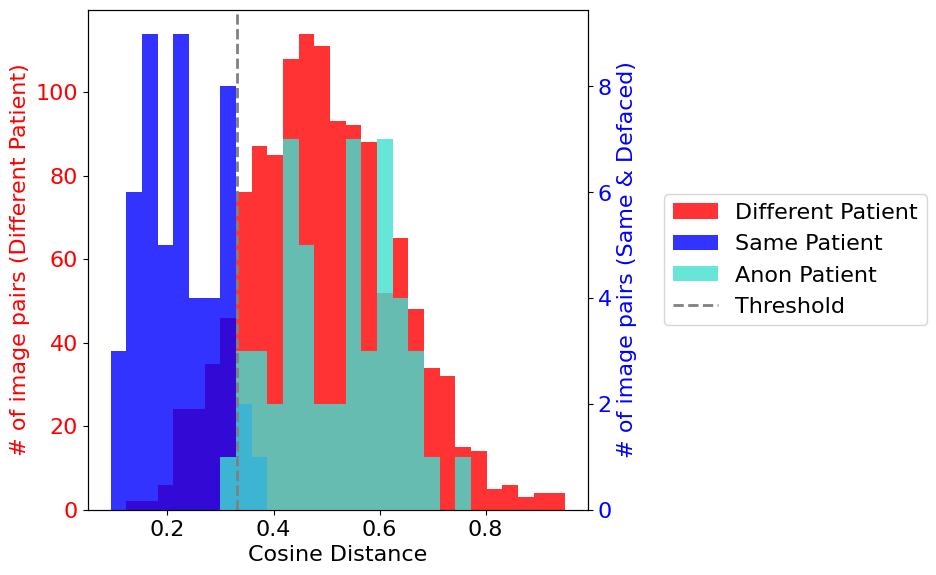

In [27]:
plot_hist_x3x3([same_list_M], [diff_list_M],[anon_list_M],threshold=optimal_threshold,density=True)

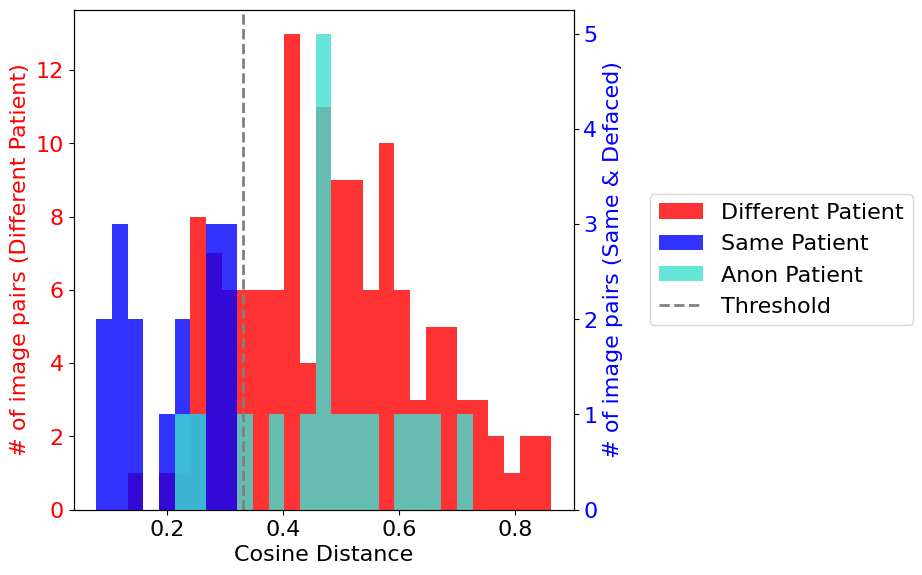

In [28]:
plot_hist_x3x3([same_list_F], [diff_list_F],[anon_list_F],threshold=optimal_threshold,density=True)

In [32]:
print("Same M:",same_list_M)
print("Diff M:",diff_list_M)
print("Anon M:",anon_list_M)

print("Same F:",same_list_F)
print("Diff F:",diff_list_F)
print("Anon F:",anon_list_F)



Same M: [0.1317052933736601, 0.3553012077712828, 0.209385800967687, 0.17436911038152536, 0.2470585598951337, 0.1379795133503613, 0.2591133287212748, 0.21322523237785052, 0.23738113533244976, 0.2325241592923436, 0.17142517928825518, 0.1043092106284893, 0.2288407047771348, 0.299653882584868, 0.17270779667994773, 0.32873111896249363, 0.31029979372696115, 0.18727560211600047, 0.13998138246803482, 0.1897806097159741, 0.3129511936718744, 0.3308530214068762, 0.3004551392475552, 0.24705530917542284, 0.14949853316581685, 0.3225068207076782, 0.2343764410289345, 0.2099648342778282, 0.3043121030362633, 0.21471848149972095, 0.16764752427245955, 0.09277341364570202, 0.17086178867628343, 0.11875230341658449, 0.28656381205105497, 0.1689056531791051, 0.21175341021121197, 0.16213349746059424, 0.32125639290081753, 0.1517782102034977, 0.2925916115715086, 0.32785319656429723, 0.1639040012272588, 0.19354959639867364, 0.14166932708564928, 0.36222532177554234, 0.2130403230262503, 0.2472934216023539, 0.2313865

In [181]:
num_matches_sM = 0
num_total_sM = 0
for p in same_dict_M.keys():
    num_total_sM+=1
    if same_dict_M[p] < optimal_threshold:
        num_matches_sM+=1
    if same_dict_M[p] > optimal_threshold:
        print(p, same_dict_M[p])

print("Same patient matches for Males:",num_matches_sM, "/", num_total_sM,"=",num_matches_sM/num_total_sM)

num_matches_sF = 0
num_total_sF = 0
for p in same_dict_F.keys():
    num_total_sF+=1
    if same_dict_F[p] < optimal_threshold:
        num_matches_sF+=1
    if same_dict_F[p] > optimal_threshold:
        print(p, same_dict_F[p])
print("Same patient matches for Females:",num_matches_sF, "/", num_total_sF,"=",num_matches_sF/num_total_sF)

54 0.3553012077712828
2027 0.36222532177554234
Same patient matches for Males: 49 / 51 = 0.9607843137254902
Same patient matches for Females: 19 / 19 = 1.0


In [182]:
num_matches_aM = 0
num_total_aM = 0
for p in anon_dict_M.keys():
    num_total_aM+=1
    if anon_dict_M[p] < optimal_threshold:
        num_matches_aM+=1
        print(p, anon_dict_M[p])

print("Anon patient matches for Males:",num_matches_aM, "/", num_total_aM,"=",num_matches_aM/num_total_aM)

num_matches_aF = 0
num_total_aF = 0
for p in anon_dict_F.keys():
    num_total_aF+=1
    if anon_dict_F[p] < optimal_threshold:
        num_matches_aF+=1
        print(p, anon_dict_F[p])

print("Anon patient matches for FeMales:",num_matches_aF, "/", num_total_aF,"=",num_matches_aF/num_total_aF)



274 0.305320297265928
Anon patient matches for Males: 1 / 51 = 0.0196078431372549
838 0.2555946552797079
1167 0.2387253969176445
Anon patient matches for FeMales: 2 / 19 = 0.10526315789473684


In [40]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
# 1) Assemble long‐form DataFrame
df = pd.DataFrame({
    'distance': same_list_M + diff_list_M + anon_list_M + same_list_F + diff_list_F + anon_list_F,
    'group':    ['same']*len(same_list_M) + ['diff']*len(diff_list_M) + ['anon']*len(anon_list_M)
              + ['same']*len(same_list_F) + ['diff']*len(diff_list_F) + ['anon']*len(anon_list_F),
    'gender':   ['M']*(len(same_list_M)+len(diff_list_M)+len(anon_list_M))
              + ['F']*(len(same_list_F)+len(diff_list_F)+len(anon_list_F))
})

# 2) rank the distances across the entire sample
df['rank_dist'] = df['distance'].rank()

# 3) fit the two-way ANOVA on ranks
model = smf.ols('rank_dist ~ C(group)*C(gender)', data=df).fit()

# 4) extract the ANOVA table
anova_results = anova_lm(model, typ=2)
print(anova_results)


                          sum_sq      df          F        PR(>F)
C(group)            3.339858e+07     2.0  93.861908  3.422526e-39
C(gender)           2.009878e+05     1.0   1.129695  2.880070e-01
C(group):C(gender)  7.635499e+04     2.0   0.214585  8.069005e-01
Residual            2.741645e+08  1541.0        NaN           NaN


In [41]:
import pandas as pd
import statsmodels.formula.api as smf

# reuse df from above

# Fit OLS on ranked distances to lessen skew
df['rank'] = df['distance'].rank()

model = smf.ols('rank ~ C(group)*C(gender)', data=df).fit()
print(model.summary())

# Joint test for all interaction coefficients
from statsmodels.stats.anova import anova_lm
anova_results = anova_lm(model, typ=2)
print(anova_results.loc['C(group):C(gender)'])


                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     38.63
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           1.88e-37
Time:                        19:39:39   Log-Likelihood:                -11543.
No. Observations:                1547   AIC:                         2.310e+04
Df Residuals:                    1541   BIC:                         2.313e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [42]:
from scipy.stats import mannwhitneyu

for grp in ['same','diff','anon']:
    m = df.loc[(df.group==grp)&(df.gender=='M'),'distance']
    f = df.loc[(df.group==grp)&(df.gender=='F'),'distance']
    stat, p = mannwhitneyu(m, f, alternative='two-sided')
    print(f"{grp}: p = {p:.3f}")


same: p = 0.395
diff: p = 0.422
anon: p = 0.444


In [ ]:
from scipy.stats import mannwhitneyu

for grp in ['same','diff','anon']:
    m = df[(df.group==grp)&(df.gender=='M')].distance
    f = df[(df.group==grp)&(df.gender=='F')].distance
    stat, p = mannwhitneyu(m, f, alternative='two-sided')
    print(grp, 'p-value:', p)


In [157]:
print("Anon patient matches:",num_matches_a, "/", num_total_a,"=",num_matches_a/num_total_a)

Anon patient matches: 3 / 70 = 0.04285714285714286


In [171]:
len(F_emb_dict)

22

In [150]:
total_A = 0
total_id_A = 0
for p in anon_dict:
    total_A+=1
    if anon_dict[p] < optimal_threshold:
        print(p, anon_dict[p])
        total_id_A+=1

274 0.305320297265928
838 0.2555946552797079
1167 0.2387253969176445


In [120]:
for p in same_dict:
    if same_dict[p] > 0.4:
        print(p, same_dict[p])

In [152]:
same_dict['638']

KeyError: '638'

In [153]:
len(list_all) - len(skip) - len(undetected)

69

In [123]:
same = []

for p in [x for x in emb_dict.keys() if x not in skip]:
    emb_A = emb_dict[p]['A'][0]['embedding']
    closest_sim = 1
    closest_p = ''
    # print("*****")
    # print(p)
    num_matches=0
    for p2 in [x for x in emb_dict.keys() if x not in skip]:
        # print(p2)
        emb_2 = emb_dict[p2]['2'][0]['embedding']
        # sim = np.dot(emb_A, emb_2) / (norm(emb_A) * norm(emb_2))

        sim =  verification.find_distance(emb_A, emb_2, 'cosine')
        # print(sim)
        if sim <optimal_threshold:
            num_matches+=1
            if p==p2:
                print("correct match found")

        # print("       "+p2 +": "+ str(sim))
        if sim < closest_sim:
            closest_sim = sim
            closest_p = p2
    print(p,":", closest_p,"--->",closest_sim)
    print(num_matches,"MATCHES")
    print("-----------------------------")
    if p == closest_p:
        same.append(p)
        

print("MATCH FOR: =",same)

19 : 734 ---> 0.31626157682646183
1 MATCHES
-----------------------------
35 : 1552 ---> 0.5035774901035986
0 MATCHES
-----------------------------
54 : 1167 ---> 0.45593595932101516
0 MATCHES
-----------------------------
59 : 1552 ---> 0.44313400601222397
0 MATCHES
-----------------------------
81 : 447 ---> 0.3460501191320059
0 MATCHES
-----------------------------
118 : 2041 ---> 0.361348230986567
0 MATCHES
-----------------------------
272 : 1552 ---> 0.42354749047682105
0 MATCHES
-----------------------------
correct match found
274 : 694 ---> 0.28165441380640177
4 MATCHES
-----------------------------
437 : 437 ---> 0.3505773416658722
0 MATCHES
-----------------------------
447 : 738 ---> 0.3353585505558049
0 MATCHES
-----------------------------
448 : 961 ---> 0.3164237924269906
1 MATCHES
-----------------------------
454 : 478 ---> 0.48596854228850284
0 MATCHES
-----------------------------
459 : 1167 ---> 0.45443467171556196
0 MATCHES
-----------------------------
462 : 1511 

In [124]:
same = []
ps_off = []

for p in [x for x in emb_dict.keys() if x not in skip]:
    emb_A = emb_dict[p]['A'][0]['embedding']
    closest_sim = 1
    closest_p = ''
    print("*****")
    print(p)
    num_matches=0
    for p2 in [x for x in emb_dict.keys() if x not in skip]:
        # print(p2)
        emb_2 = emb_dict[p2]['2'][0]['embedding']
        sim =  verification.find_distance(emb_A, emb_2, 'cosine')
        
        if p2 != p:
            emb_3 = emb_dict[p2]['1'][0]['embedding']
            sim3 =  verification.find_distance(emb_A, emb_3, 'cosine')
        # sim = np.dot(emb_A, emb_2) / (norm(emb_A) * norm(emb_2))

      
        # print(sim)
        if sim <optimal_threshold:
            print(p2,sim)
            ps_off.append(p2)
            num_matches+=1
            if p==p2:
                print("correct match found!!!!")
        
        # print("       "+p2 +": "+ str(sim))
        if sim < closest_sim:
            closest_sim = sim
            closest_p = p2
        if p2 != p:
            if sim3 <optimal_threshold:
                ps_off.append(p2)
                num_matches+=1
                print(p2,sim3)
            if sim3 < closest_sim:
                closest_sim = sim3
                closest_p = p2
    if num_matches > 0:
        print(p,":", closest_p,"--->",closest_sim)
        print(num_matches,"MATCHES")
        print("-----------------------------")
    if p == closest_p:
        same.append(p)
        

print("MATCH FOR: =",same)

*****
19
734 0.31626157682646183
19 : 734 ---> 0.31626157682646183
1 MATCHES
-----------------------------
*****
35
*****
54
*****
59
54 0.3081393330778601
59 : 54 ---> 0.3081393330778601
1 MATCHES
-----------------------------
*****
81
*****
118
*****
272
*****
274
274 0.305320297265928
correct match found!!!!
685 0.32031248418894
694 0.28165441380640177
694 0.3240092652748129
965 0.32157659299290287
274 : 694 ---> 0.28165441380640177
5 MATCHES
-----------------------------
*****
437
*****
447
892 0.32228950232556286
447 : 892 ---> 0.32228950232556286
1 MATCHES
-----------------------------
*****
448
518 0.32984030994210856
662 0.22604935234769175
961 0.3164237924269906
448 : 662 ---> 0.22604935234769175
3 MATCHES
-----------------------------
*****
454
*****
459
*****
462
600 0.3188522726559837
773 0.30139346901844366
1502 0.29404053621572446
1511 0.2418209629473601
462 : 1511 ---> 0.2418209629473601
4 MATCHES
-----------------------------
*****
469
1987 0.3170955672108875
469 : 1987

In [125]:
off_d = dict(Counter(ps_off))
dict(sorted(off_d.items(), key=lambda item: item[1], reverse=True))

{'721': 8,
 '1288': 7,
 '1167': 7,
 '694': 6,
 '628': 6,
 '1949': 5,
 '685': 4,
 '662': 4,
 '2061': 4,
 '892': 3,
 '961': 3,
 '673': 3,
 '790': 3,
 '734': 2,
 '518': 2,
 '600': 2,
 '773': 2,
 '1502': 2,
 '1511': 2,
 '1987': 2,
 '755': 2,
 '2056': 2,
 '478': 2,
 '644': 2,
 '848': 2,
 '54': 1,
 '274': 1,
 '965': 1,
 '2058': 1,
 '2027': 1,
 '517': 1,
 '454': 1,
 '1892': 1,
 '838': 1,
 '625': 1,
 '738': 1,
 '1552': 1}

In [126]:
same = []
diff = []
offenders = []
off = ['937']#['625','662']
same23 = []
for p in [x for x in emb_dict.keys() if x not in skip and x not in off]:
    
    emb_A = emb_dict[p]['1'][0]['embedding']
    closest_sim = 1
    closest_p = ''
    closest_sim2 = 1
    closest_p2 = ''
    closest_sim3 = 1
    closest_p3 = ''
    # print("*****")
    # print(p)
    num_matches = 0
    for p2 in [x for x in emb_dict.keys() if x not in skip and x not in off]:
        # print(p2)
        emb_2 = emb_dict[p2]['2'][0]['embedding']
        sim = verification.find_distance(emb_A, emb_2, 'cosine')
        if sim<optimal_threshold:
            num_matches+=1
        if p == p2:
            print("Same p:",sim)
        # print("       "+p2 +": "+ str(sim))
        if sim < closest_sim:
            closest_sim = sim
            closest_p = p2
        elif sim < closest_sim2:
            closest_sim2 = sim
            closest_p2 = p2
        elif sim < closest_sim3:
            closest_sim3 = sim
            closest_p3 = p2
    print(p,":", closest_p, closest_p2, closest_p3)
    print("clostest p:",closest_sim)
    print(num_matches, "MATCHES")
    print("********")
    if p == closest_p:
        same.append(p)
    elif p== closest_p2 or p==closest_p3:
        same23.append(p)
    
    else:
        diff.append(p)
        offenders.append(p)
        offenders.append(closest_p)
        offenders.append(closest_p2)
        offenders.append(closest_p3)

print("NOT A MATCH FOR: ",len(diff),"PATIENTS =",diff)

print("Direct match for:", same)
print("2nd 3rd match for:",same23)

Same p: 0.1317052933736601
19 : 19 770 600
clostest p: 0.1317052933736601
14 MATCHES
********
Same p: 0.17615651409333244
35 : 35 1892 517
clostest p: 0.17615651409333244
1 MATCHES
********
Same p: 0.3553012077712828
54 : 59 1552 2056
clostest p: 0.35423449669062756
0 MATCHES
********
Same p: 0.2693015382267838
59 : 1255 945 786
clostest p: 0.1612511368067232
9 MATCHES
********
Same p: 0.209385800967687
81 : 81 474 945
clostest p: 0.209385800967687
14 MATCHES
********
Same p: 0.17436911038152536
118 : 118 474 462
clostest p: 0.17436911038152536
17 MATCHES
********
Same p: 0.2470585598951337
272 : 272 738 973
clostest p: 0.2470585598951337
4 MATCHES
********
Same p: 0.1379795133503613
274 : 478 454 1987
clostest p: 0.13119912320271399
6 MATCHES
********
Same p: 0.2591133287212748
437 : 474 2037 1255
clostest p: 0.23433803442709544
3 MATCHES
********
Same p: 0.21322523237785052
447 : 19 600 738
clostest p: 0.17580999909250272
22 MATCHES
********
Same p: 0.23738113533244976
448 : 448 965 

In [127]:
offenders_dict = dict(Counter(offenders))
dict(sorted(offenders_dict.items(), key=lambda item: item[1], reverse=True))

{'1511': 5,
 '973': 5,
 '1552': 4,
 '2056': 4,
 '1949': 4,
 '946': 4,
 '1288': 4,
 '59': 3,
 '1255': 3,
 '945': 3,
 '600': 3,
 '738': 3,
 '651': 3,
 '1892': 3,
 '517': 3,
 '1502': 3,
 '790': 3,
 '454': 2,
 '1987': 2,
 '474': 2,
 '447': 2,
 '2058': 2,
 '2027': 2,
 '965': 2,
 '820': 2,
 '54': 1,
 '786': 1,
 '274': 1,
 '478': 1,
 '437': 1,
 '2037': 1,
 '19': 1,
 '518': 1,
 '961': 1,
 '2017': 1,
 '662': 1,
 '673': 1,
 '685': 1,
 '734': 1,
 '755': 1,
 '773': 1,
 '833': 1,
 '483': 1,
 '1888': 1,
 '1314': 1}

### Add random faces

In [57]:
PATH_real= PATH + 'faces/'

In [58]:
reals = os.listdir(PATH_real)
print(reals)

['1 (21).png', '1 (16).png', '1 (13).png', '1 (34).png', '1 (10).png', '1 (10).jpg', '1 (30).jpg', '1 (16).jpg', '1 (30).png', '1 (32).jpg', '1 (5).png', '1 (3).jpg', '1 (21).jpg', '1 (22).png', '1 (29).jpg', '1 (23).png', '1 (29).jpeg', '1 (12).jpg', '1 (17).jpeg', '1 (14).jpg', '1 (27).jpeg', '1 (31).jpg', '1 (28).jpg', '1 (2).png', '1 (32).png', '1 (5).jpeg', '1 (31).png', '1 (13).jpg', '1 (18).png', '1 (23).jpeg', '1 (6).png', '1 (3).jpeg', '1 (20).jpeg', '1 (19).png', '1 (22).jpeg', '1 (5).jpg', '1 (7).png', '1 (30).jpeg', '1 (18).jpeg', '1 (3).png', '1 (35).jpg', '1 (20).png', '1 (8).jpeg', '1 (15).png', '1 (12).jpeg', '1 (9).jpg', '1 (35).jpeg', '1 (7).jpeg', '1 (11).png', '1 (34).jpg', '1 (15).jpg', '1 (31).jpeg', '1 (26).png', '1 (33).jpg', '1 (19).jpg', '1 (22).jpg', '1 (27).png', '1 (25).jpeg', '1 (14).jpeg', '1 (9).jpeg', '1 (23).jpg', '1 (17).png', '1 (2).jpg', '1 (24).jpg', '1 (16).jpeg', '1 (24).jpeg', '1 (13).jpeg', '1 (33).png', '1 (2).jpeg', '1 (15).jpeg', '1 (32).jpe

In [60]:
# for r in reals:
#     new_strnig = r.split("(")[1].split(")")[0]
#     print(new_strnig)

In [62]:
emb_dict_real = {}


for person in reals:
    emb_dict_real[person]= DeepFace.represent(img_path = PATH_real+person, enforce_detection=True,detector_backend='retinaface',model_name='Facenet512') 


In [65]:

    
dist_dict = {}
dist_list = []
list_to_do = [p for p in list(emb_dict.keys()) if p not in skip]
for p1 in [p for p in list(emb_dict.keys()) if p not in skip and p not in undetected] :
  
    dist_dict[p1] = {}
    for p2 in reals:            

        v_a = emb_dict[p1]['1'][0]['embedding']
        v_b = emb_dict_real[p2][0]['embedding']
        # to do -- change 0 to be taken before
        
        dist = verification.find_distance(v_a, v_b, 'cosine')
      
        dist_dict[p1][p2] = dist
        dist_list.append(dist)
    

In [66]:
dist_list

[0.9491717050806447,
 1.177703438460719,
 0.8354273714419547,
 0.9425443254945878,
 0.9975614888487212,
 0.752873040447733,
 1.0848796174928306,
 1.0489468855719752,
 0.7613663695121767,
 0.8579296063194712,
 0.9551889914957632,
 0.7926638596396718,
 1.0398642031248322,
 0.9551889914957632,
 1.056728215094433,
 0.9551889914957632,
 0.9915813865916661,
 1.04715960755995,
 1.0348888890698709,
 0.9045461954302301,
 0.9580536051872975,
 0.9721105243295414,
 0.9584741546650151,
 0.9551889914957632,
 0.8843171459656912,
 0.9169076921553102,
 1.2357750697725696,
 0.8303643222035926,
 0.9551889914957632,
 1.132612733474891,
 0.924332025147952,
 1.0348888890698709,
 1.0341938264712407,
 0.9551889914957632,
 1.1307320607797324,
 0.9494428684551156,
 0.9792903616343429,
 0.9550352269804947,
 1.1222300009062736,
 0.7613663695121767,
 0.8184355838628364,
 0.9425443254945878,
 1.1222300009062736,
 0.9425443254945878,
 1.1222300009062736,
 0.9494428684551156,
 1.0132389635499148,
 0.6793691288602247,

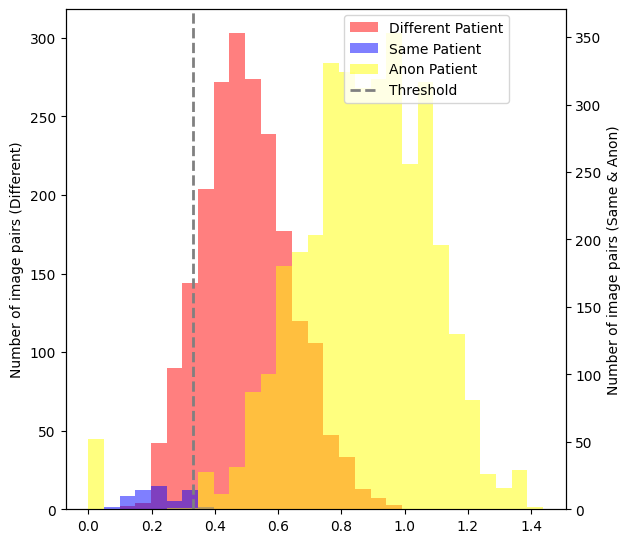

In [91]:
plot_hist_x3x3([same_list], [diff_list],[dist_list2],threshold=optimal_threshold)

In [68]:
r_8 = DeepFace.represent(img_path = PATH+'Untitled.png', enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')

In [73]:
r = r_8[0]['embedding']
f = emb_dict['838']['1'][0]['embedding']

In [75]:
verification.find_distance(r,f,'cosine')

0.8222483647293588

In [81]:
import tensorflow as tf

# Load the pre-trained FaceNet512 model
model = DeepFace.build_model('Facenet512')

# Set the layers you want to fine-tune to be trainable
for layer in model.layers:
    layer.trainable = False  # Freeze all layers
model.layers[-2].trainable = True  # Unfreeze the last layer for fine-tuning

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy')

# Train the model on your dataset
model.fit(train_data, train_labels, epochs=10, batch_size=32)

AttributeError: 'FaceNet512dClient' object has no attribute 'layers'

In [82]:
model

In [84]:
print(model.keys())


AttributeError: 'FaceNet512dClient' object has no attribute 'keys'

In [85]:
from tensorflow.keras import layers, models

In [86]:
base_model = model

In [87]:
x = base_model.output

AttributeError: 'FaceNet512dClient' object has no attribute 'output'

In [90]:
dist_dict2 = {}
dist_list2 = []
list_to_do = reals
for p1 in reals :
    list_to_do.remove(p1)
    dist_dict2[p1] = {}
    for p2 in list_to_do:            

        v_a = emb_dict_real[p1][0]['embedding']
        v_b = emb_dict_real[p2][0]['embedding']
        # to do -- change 0 to be taken before
        
        dist = verification.find_distance(v_a, v_b, 'cosine')
      
        dist_dict2[p1][p2] = dist
        dist_list2.append(dist)
        

In [114]:
def process_images(p, path):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    image_paths = [f"{path}{p}_1.png", f"{path}{p}_2.png", f"{path}{p}_A.png"]
    titles = [f"Patient: {p} - Image 1", f"Patient: {p} - Image 2", f"Patient: {p} - Image A"]
    results = []
    
    for i, image_path in enumerate(image_paths):
        try:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            detect = DeepFace.extract_faces(image_path, detector_backend='retinaface')
            facial_area = detect[0]['facial_area']
            confidence = detect[0]['confidence']
            
            x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 1)
            
            left_eye = facial_area['left_eye']
            right_eye = facial_area['right_eye']
            
            ax = axes[i]
            ax.imshow(image)
            ax.scatter(*left_eye, color='red', s=50, label='Left Eye')
            ax.scatter(*right_eye, color='blue', s=50, label='Right Eye')
            ax.set_title(titles[i])
            ax.axis('off')
            ax.legend()
            
            results.append(f"{titles[i]}: {facial_area}, {confidence}")
        except Exception as e:
            results.append(f"{titles[i]}: No face detected or error: {e}")
    
    plt.tight_layout()
    plt.show()
    return results

# for p in [l for l in list_all if l not in skip]:
#     print(p)
#     results = process_images(p, PATH)
#     print(" | ".join(results))

In [323]:
# for p in [l for l in list_all if l not in undetected]:
#     print(p)
#     results = process_images(p, PATH)
#     print(" | ".join(results))

In [116]:
# 467
# 478 no img found
#633 eyes, no img found
#694 no img
#1892 no img
# 2037 no img



In [119]:
skip.remove('35')

In [118]:
undetected

['638', '721', '1502', '35']

In [193]:
skip.sort()
print(skip)

['1552', '1763', '1955', '35', '452', '467', '638', '70', '908', '964']


In [68]:
p='517'
a=DeepFace.represent(img_path = PATH+p+"_1"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')[0]['embedding']
b=DeepFace.represent(img_path = PATH+p+"_2"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')[0]['embedding']
A = DeepFace.represent(img_path = PATH+p+"_A"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')[0]['embedding']

In [69]:
verification.find_distance(a,b,'cosine')

0.1466332098529659

In [70]:
verification.find_distance(A,b,'cosine')

0.5410185330957678

In [186]:
skip

['638', '35', '70', '452', '467', '908', '1763', '1955', '964', '1552']

In [27]:
for p in ['721','1502']:
    emb_dict[p] = {}
    emb_dict[p]['1'] =DeepFace.represent(img_path = PATH+p+"_1"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')
    emb_dict[p]['2'] =DeepFace.represent(img_path = PATH+p+"_2"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')
    emb_dict[p]['A'] =DeepFace.represent(img_path = PATH+p+"_A"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.stats import levene

# Generate t-SNE representation
def compute_tsne(embeddings, perplexity=50):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_results = tsne.fit_transform(np.array(embeddings))
    return tsne_results

# Compute mean deviation
def compute_deviations(points, centroid):
    deviations = np.linalg.norm(points - centroid, axis=1)
    return deviations

# Plot t-SNE and calculate deviations
def plot_tsne_clusters(dict_emb, num=['1', '2'], skip=[],perplexity=30,plot=True):
    X = []
    labels = []
    n_labels = []
    for p in [x for x in dict_emb if x not in skip]:
        for n in num:
            X.append(dict_emb[p][n][0]['embedding'])
            labels.append(p)
            n_labels.append(n)
    
    tsne_results = compute_tsne(X,perplexity)
    df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
    df_tsne['label'] = labels
    df_tsne['n_labels'] = n_labels
    
   
    # Create a custom palette dictionary
    unique_labels = np.unique(labels)
 
    # Calculate centroids and deviations
    within_cluster_devs = []
    centroids = []
    
    for label in unique_labels:
        cluster_points = tsne_results[df_tsne['label'] == label]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        deviations = compute_deviations(cluster_points, centroid)
        within_cluster_devs.append(deviations)
    
    between_cluster_dev = compute_deviations(np.array(centroids), np.mean(centroids, axis=0))
    
    # Levene's test for variance equality
    stat, p_value = levene(*within_cluster_devs)
    
    # Print deviations and p-value
    print(f"Within-cluster deviation: {np.mean([np.mean(dev) for dev in within_cluster_devs])}")
    print(f"Between-cluster deviation: {np.mean(between_cluster_dev)}")
    print(f"P-value: {p_value}")
    print(f"Ratio between cluster/within cluster deviation: { np.mean(between_cluster_dev) /np.mean([np.mean(dev) for dev in within_cluster_devs])}")

    if plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        colours = [
            '#FF0000', '#0000FF', '#FF00FF', '#00FFFF', '#FFA500', '#00FF00', '#FFFF00', '#008000', '#800080', '#FA8072',
            '#5F9EA0', '#808000', '#FFC0CB', '#A52A2A', '#000000', '#46dee4', '#808080', '#000080', '#008080', '#800000',
            '#FFD700', '#C0C0C0', '#FF7F50', '#4B0082', '#EE82EE', '#40E0D0', '#F0E68C', '#E6E6FA', '#228B22', '#F5F5DC',
            '#DC143C', '#FF00FF', '#87CEEB', '#7FFF00', '#D2691E', '#98FF98', '#FFE5B4', '#DA70D6', '#e1feaf', '#007FFF',
            '#50C878', '#E0115F', '#0F52BA', '#D2B48C', '#CCCCFF', '#FFDB58', '#FBCEB1', '#D8BFD8', '#007BA7', '#F5DEB3',
            '#DE5D83', '#B87333', '#FFF700', '#A0522D', '#4605f6', '#FF6347', '#36454F', '#00FFFF', '#9966CC','#535970',
            '#2a8373','#7e338e','#73d635','#93550a','#fb17a8','#a6c878','#4a29a9','#3d5c92','#f2e390'
        ]
    
        palette = dict(zip(unique_labels, colours[:len(unique_labels)]))
        
        sns.scatterplot(x='x', y='y', s=100, hue='label', palette=palette, data=df_tsne, ax=ax)
        x = df_tsne['x'].values
        y = df_tsne['y'].values
        
        # Add text annotations
        for i, txt in enumerate(df_tsne['label']):
            if df_tsne['n_labels'][i] == 'A':
                txt = txt +"_A"
            # plt.text(x[i], y[i], txt, fontsize=10, ha='center', va='bottom')
                
                    
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
        plt.show()

In [141]:
for perplexity in [5,10,15,20,25,30,35,40,45,50]:
    print("**************************************************")
    print("Perplexity:", perplexity)
    plot_tsne_clusters(emb_dict,['1','2'],skip=skip+['1502'],perplexity=perplexity,plot=False)
    

**************************************************
Perplexity: 5
Within-cluster deviation: 4.964559555053711
Between-cluster deviation: 25.09090805053711
P-value: 1.2681069808187982e-23
Ratio between cluster/within cluster deviation: 5.054004669189453
**************************************************
Perplexity: 10
Within-cluster deviation: 4.509432792663574
Between-cluster deviation: 17.581708908081055
P-value: 4.989513649010785e-17
Ratio between cluster/within cluster deviation: 3.898873805999756
**************************************************
Perplexity: 15
Within-cluster deviation: 3.2235043048858643
Between-cluster deviation: 14.869057655334473
P-value: 2.3730567935643243e-22
Ratio between cluster/within cluster deviation: 4.61269998550415
**************************************************
Perplexity: 20
Within-cluster deviation: 2.0264697074890137
Between-cluster deviation: 9.583263397216797
P-value: 5.5791911634206984e-21
Ratio between cluster/within cluster deviation: 4.729

Within-cluster deviation: 4.964559555053711
Between-cluster deviation: 25.09090805053711
P-value: 1.2681069808187982e-23
Ratio between cluster/within cluster deviation: 5.054004669189453


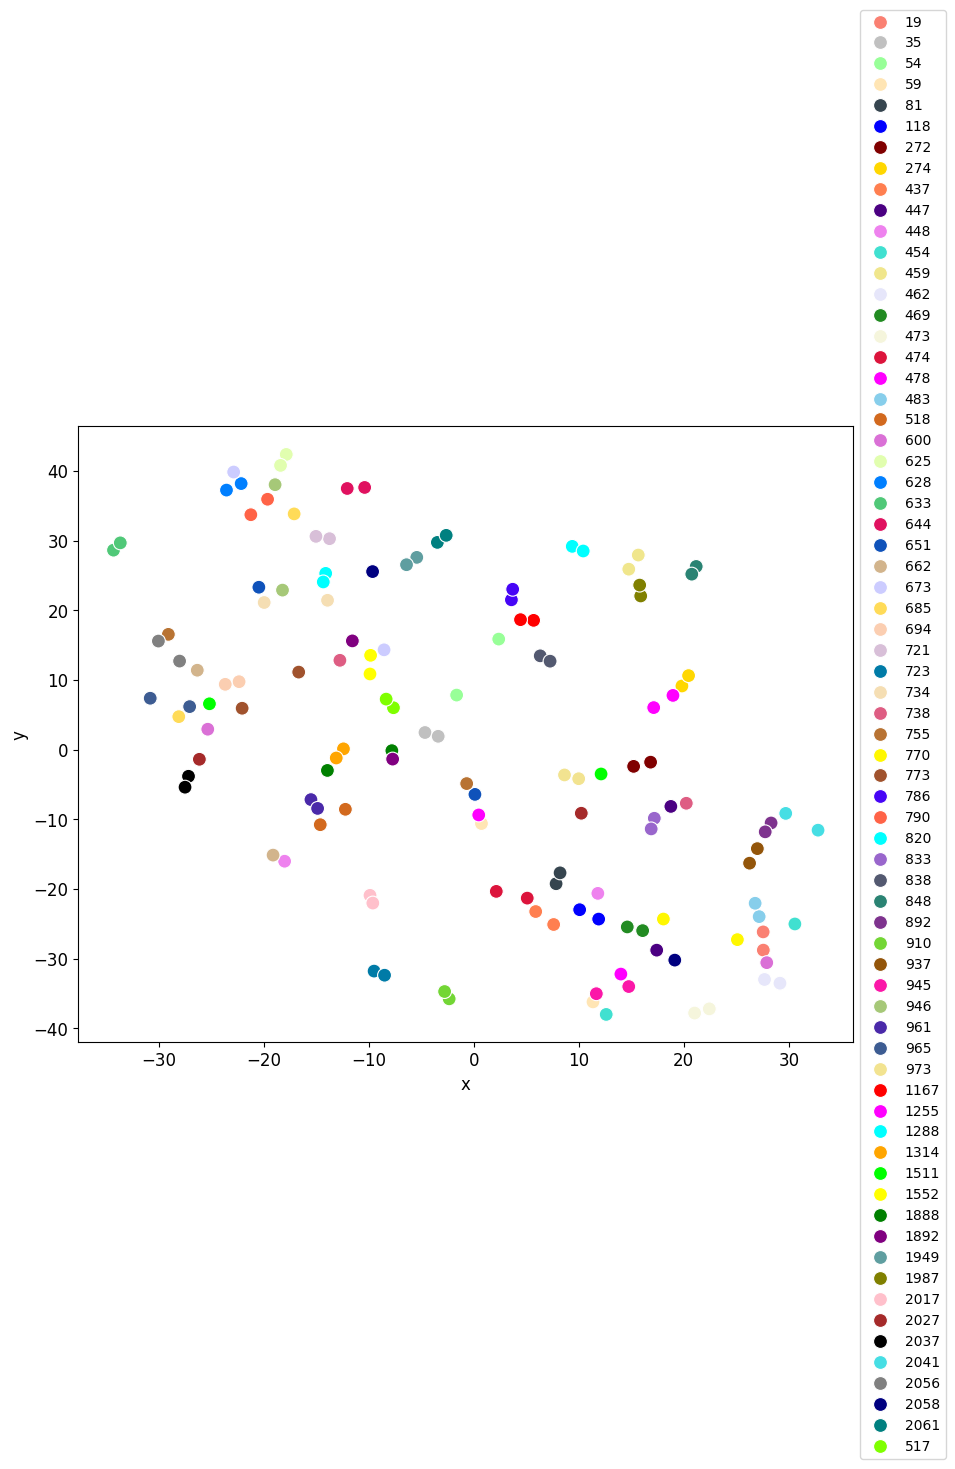

In [146]:
plot_tsne_clusters(emb_dict,['1','2'],skip=skip+['1502'],perplexity=5)

Within-cluster deviation: 23.665172576904297
Between-cluster deviation: 13.609566688537598
P-value: 0.18207654066373435
Ratio between cluster/within cluster deviation: 0.5750884413719177


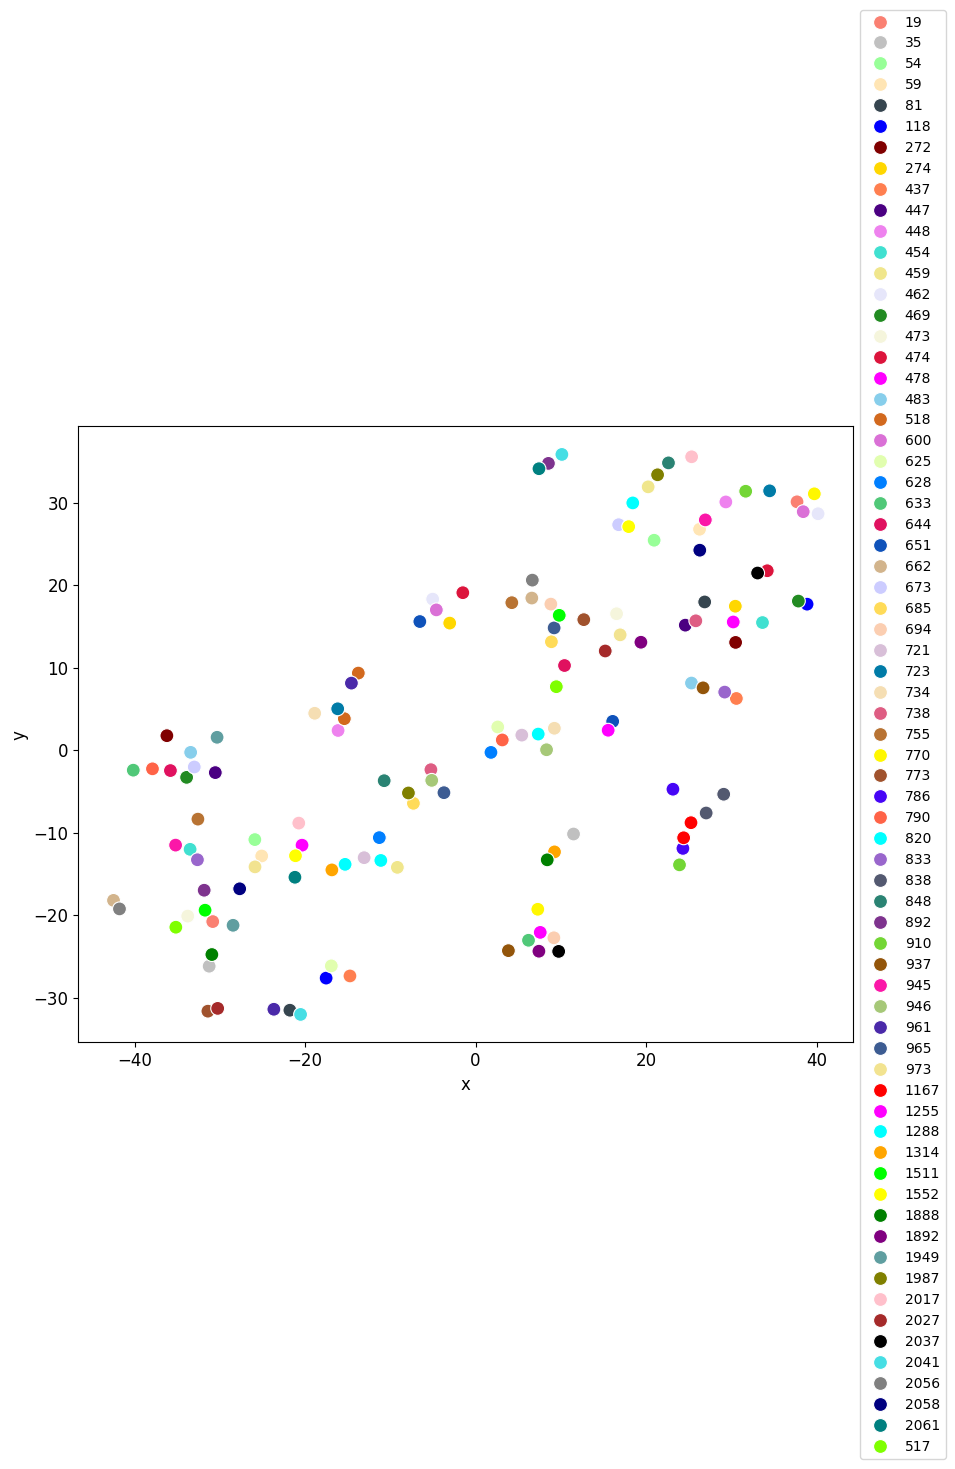

In [147]:
plot_tsne_clusters(emb_dict,['A','2'],skip=skip+['1502'],perplexity=5)

In [144]:
def get_cluster_dists(num, dict_emb):
    X = []
    labels = []
    n_labels = []
    for p in [x for x in dict_emb if x not in skip + ['1502']]:
        for n in num:
            X.append(dict_emb[p][n][0]['embedding'])
            labels.append(p)
            n_labels.append(n)

    # Here, we skip the t-SNE part and use the embeddings directly
    df_emb = pd.DataFrame(X)
    df_emb['label'] = labels
    df_emb['n_labels'] = n_labels

    within_cluster_devs = []
    centroids = []

    unique_labels = df_emb['label'].unique()
    for label in unique_labels:
        cluster_points = df_emb[df_emb['label'] == label].iloc[:, :-2]  # Exclude label columns
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        deviations = compute_deviations(cluster_points, centroid)
        within_cluster_devs.append(deviations)

    between_cluster_dev = compute_deviations(np.array(centroids), np.mean(centroids, axis=0))

   

    # Levene's test for variance equality
    print("Debug info: ", within_cluster_devs)  # Add this line
    stat, p_value = levene(*within_cluster_devs)

    # Print deviations and p-value
    print(f"Within-cluster deviation: {np.mean([np.mean(dev) for dev in within_cluster_devs])}")
    print(f"Between-cluster deviation: {np.mean(between_cluster_dev)}")
    print(f"P-value: {p_value}")
    print(f"Ratio between cluster/within cluster deviation: {np.mean(between_cluster_dev) / np.mean([np.mean(dev) for dev in within_cluster_devs])}")

In [298]:
get_cluster_dists(['1','2'],emb_dict)

Within-cluster deviation: 7.5483595483079915
Between-cluster deviation: 13.976041684850145
P-value: nan
Ratio between cluster/within cluster deviation: 1.851533647199272


In [297]:
get_cluster_dists(['A','2'],emb_dict)

Within-cluster deviation: 10.919963273825486
Between-cluster deviation: 12.253380580360304
P-value: nan
Ratio between cluster/within cluster deviation: 1.1221082226284536


In [296]:
from scipy.stats import bartlett

def get_cluster_dists(num, dict_emb):
    X = []
    labels = []
    n_labels = []
    for p in [x for x in dict_emb if x not in skip + ['1502']]:
        for n in num:
            X.append(dict_emb[p][n][0]['embedding'])
            labels.append(p)
            n_labels.append(n)

    df_emb = pd.DataFrame(X)
    df_emb['label'] = labels
    df_emb['n_labels'] = n_labels

    within_cluster_devs = []
    centroids = []

    unique_labels = df_emb['label'].unique()
    for label in unique_labels:
        cluster_points = df_emb[df_emb['label'] == label].iloc[:, :-2]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        deviations = compute_deviations(cluster_points, centroid)
        within_cluster_devs.append(deviations)

    between_cluster_dev = compute_deviations(np.array(centroids), np.mean(centroids, axis=0))

    # Bartlett's test for variance equality
    stat, p_value = bartlett(*within_cluster_devs)

    # Print deviations and p-value
    print(f"Within-cluster deviation: {np.mean([np.mean(dev) for dev in within_cluster_devs])}")
    print(f"Between-cluster deviation: {np.mean(between_cluster_dev)}")
    print(f"P-value: {p_value}")
    print(f"Ratio between cluster/within cluster deviation: {np.mean(between_cluster_dev) / np.mean([np.mean(dev) for dev in within_cluster_devs])}")


In [353]:
from scipy.spatial.distance import euclidean

def compare_pairs(dict_emb,skip):
    distances_before = []
    distances_after = []
    centroids_before = []
    centroids_after = []
    for p in [p for p in dict_emb if p not in skip]:
        if p not in skip + ['1502']:
            before_embedding_1 = dict_emb[p]['1'][0]['embedding']
            before_embedding_2 = dict_emb[p]['2'][0]['embedding']
            after_embedding = dict_emb[p]['A'][0]['embedding']
            distance_before = verification.find_distance(before_embedding_1,before_embedding_2,'euclidean')
            # print(distance_before)
            distance_after = verification.find_distance(before_embedding_2,after_embedding,'euclidean')
            distances_before.append(distance_before)
            distances_after.append(distance_after)

            centroid_before = np.mean([before_embedding_1, before_embedding_2], axis=0)
            centroids_before.append(centroid_before)
            
           
            centroid_after = np.mean([after_embedding, before_embedding_2], axis=0)
            centroids_after.append(centroid_after)
    
    mean_distance_before = np.mean(distances_before)
    mean_distance_after = np.mean(distances_after)

    distances = 
    [euclidean(c_before, c_after) for c_before, c_after in zip(centroids_before, centroids_after)]
    
    mean_distance = np.mean(distances)
    
    print(f"Mean centroid distance before and after defacing: {mean_distance}")


    
    print(f"Mean distance before defacing: {mean_distance_before}")
    print(f"Mean distance after defacing: {mean_distance_after}")
    
    print(f"Mean distance before defacing: {mean_distance_before}")
    print(f"Mean distance after defacing: {mean_distance_after}")



In [354]:
compare_pairs(emb_dict,skip+undetected+['1502'])

[11.484766927878185, 7.048254145230781, 12.90832821324416, 11.002589967171815, 9.276983925898488, 9.42415318318723, 8.110660658857292, 8.4114201414244, 9.054758864550129, 8.7227068385558, 13.180539521234856, 9.302619364115237, 10.407574711877437, 11.13380891380231, 10.828045904376422, 10.89189222886613, 11.530232823416531, 10.338955057754209, 6.998587280202672, 8.150898027970605, 9.421090333381871, 10.391874036841369, 7.668255733324805, 9.042338679277433, 8.50501413410587, 11.516601273000191, 8.922287996572834, 7.371673747782349, 9.725835426858174, 10.551357159539945, 11.178357839004933, 8.62550604650278, 11.17668976894635, 11.173619147100371, 8.297268625649641, 7.362179107029194, 10.361629731617532, 11.104157921639311, 9.936284677072193, 6.7203353785984055, 10.75712541600413, 11.68157194114114, 10.549306129769557, 8.837273050856902, 11.08394334835978, 7.069689120290675, 8.19039759223653, 10.651371102040649, 11.921669665219667, 6.792611001032456, 11.859270413179136, 7.666982018077908, 

In [372]:

def compare_defaced_embeddings(dict_emb, skip=[]):
    distances_before = []
    distances_after = []
    
    for p in [p for p in dict_emb if p not in skip]:
        before_embedding_1 = dict_emb[p]['1'][0]['embedding']
        before_embedding_2 = dict_emb[p]['2'][0]['embedding']
        after_embedding = dict_emb[p]['A'][0]['embedding']
        
        # Calculate centroid for the "before" embeddings
        centroid_before = np.mean([before_embedding_1, before_embedding_2], axis=0)
        
        # Calculate distances
        distance_before = euclidean(before_embedding_1, before_embedding_2)
        distance_after = euclidean(centroid_before, after_embedding)
        
        distances_before.append(distance_before)
        distances_after.append(distance_after)
    
    # Plot distributions
    plt.figure(figsize=(10, 5))
    plt.hist(distances_before, alpha=0.5, label='Before Defacing')
    plt.hist(distances_after, alpha=0.5, label='After Defacing')
    plt.legend(loc='upper right')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Distances Before and After Defacing')
    plt.show()
    
    mean_distance_before = np.mean(distances_before)
    mean_distance_after = np.mean(distances_after)
    print(f"Mean distance before defacing: {mean_distance_before}")
    print(f"Mean distance after defacing: {mean_distance_after}")



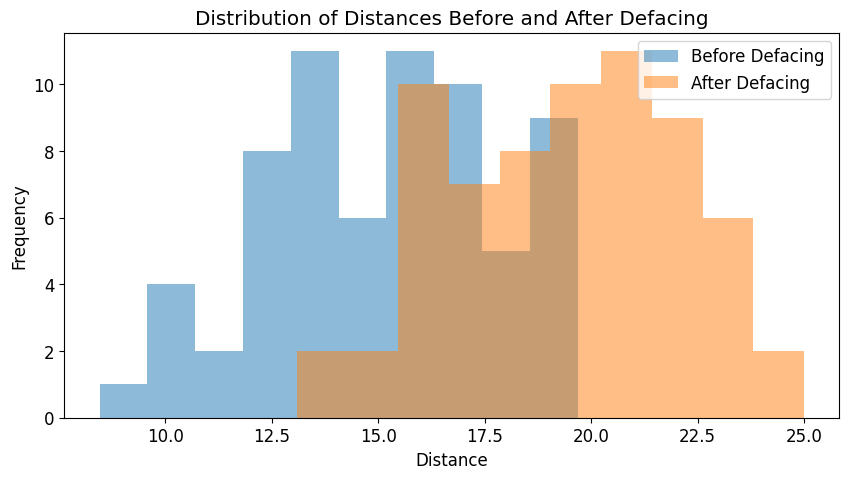

Mean distance before defacing: 15.09671909661599
Mean distance after defacing: 19.29184077779783


In [373]:
compare_defaced_embeddings(emb_dict, skip=skip+['1502'])

## Stats

In [3]:
import scipy.stats as stats

In [36]:

emb_a = []
emb_1 = []
emb_2 = []

for p in [p for p in list(emb_dict.keys()) if p not in skip]:
    # print(p)
    emb_a.append(np.array(emb_dict[p]['A'][0]['embedding']))
    emb_1.append(np.array(emb_dict[p]['1'][0]['embedding']))
    emb_2.append(np.array(emb_dict[p]['2'][0]['embedding']))

In [59]:

def KS_test(emb_list,comp = 'norm'):
    ks_stat, ks_p_value = stats.kstest(emb_list, comp, args=(np.mean(emb_list), np.std(emb_list)))
    print("Kolmogorov-Smirnov test statistic:", ks_stat)
    print("p-value for KS test:", ks_p_value)

In [51]:
def ManU_test(list1, list2,significance_level=0.05):
    mwu_stat, mwu_p_value = stats.mannwhitneyu(list1, list2, alternative='two-sided')
    print("Mann-Whitney U test statistic:", mwu_stat)
    print("p-value for Mann-Whitney U test:", mwu_p_value)
    # print("Significance for KS test:", ks_p_value < significance_level)
    print("Significance for Mann-Whitney U test:", mwu_p_value < significance_level)

In [54]:
def WC(list1,list2,significance_level=0.05):
    wc_stat, wc_p_value = stats.wilcoxon(list1,list2)
    print("Wilcoxon test statistic:", wc_stat)
    print("p-value for WC test:", wc_p_value)
    print("Significance for Wilcoxon test:", wc_p_value < significance_level)

In [60]:
print("Same vs norm")
KS_test(np.array(same_list))
print("Diff vs norm")
KS_test(diff_list)
print("Anon vs norm")
KS_test(anon_list)
print("_______________________")
print("Same vs Diff")
ManU_test(same_list,diff_list)
KS_test(same_list,diff_list)
# WC(same_list,diff_list)
print("_______________________")
print("Diff vs Anon")
ManU_test(diff_list,anon_list)
KS_test(diff_list,anon_list)
# WC(diff_list,anon_list)
print("_______________________")
print("Same vs Anon")
ManU_test(same_list,anon_list)
WC(same_list,anon_list)

Same vs norm
Kolmogorov-Smirnov test statistic: 0.10975757490220694
p-value for KS test: 0.3594469492590991
Diff vs norm
Kolmogorov-Smirnov test statistic: 0.028340938961883555
p-value for KS test: 0.050515135908591136
Anon vs norm
Kolmogorov-Smirnov test statistic: 0.07542799044066117
p-value for KS test: 0.8060814403537048
_______________________
Same vs Diff
Mann-Whitney U test statistic: 4628.0
p-value for Mann-Whitney U test: 5.8543111890547335e-40
Significance for Mann-Whitney U test: True
Kolmogorov-Smirnov test statistic: 0.8687445127304653
p-value for KS test: 1.4888163160761407e-57
_______________________
Diff vs Anon
Mann-Whitney U test statistic: 72770.0
p-value for Mann-Whitney U test: 0.3950324987739292
Significance for Mann-Whitney U test: False
Kolmogorov-Smirnov test statistic: 0.11567164179104478
p-value for KS test: 0.3157479963772719
_______________________
Same vs Anon
Mann-Whitney U test statistic: 68.0
p-value for Mann-Whitney U test: 1.5998778811348993e-22
Signi

In [ ]:


# # Kolmogorov-Smirnov test for normality

    
# Mann-Whitney U test for comparing means of two groups
group1 = pd.to_numeric(df[df['actualReplan'] == 'Y'][category]).dropna()
group2 = pd.to_numeric(df[df['actualReplan'] == 'N'][category]).dropna()
mwu_stat, mwu_p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print("Mann-Whitney U test statistic:", mwu_stat)
print("p-value for Mann-Whitney U test:", mwu_p_value)
print("Significance for KS test:", ks_p_value < significance_level)
print("Significance for Mann-Whitney U test:", mwu_p_value < significance_level)

### Sample size calculations

In [3]:
import math
from scipy.stats import norm

def calculate_sample_sizes(alpha=0.05, power=0.8, effect_size=0.5):
    # Calculate the critical Z value for a two-tailed test:
    # For a significance level of alpha (0.05), each tail has alpha/2 = 0.025.
    # Thus, the Z value corresponding to 1 - 0.025 = 0.975 cumulative probability is:
    z_alpha_over_2 = norm.ppf(1 - alpha/2)  # Approximately 1.96
    # Calculate the Z value corresponding to the desired power:
    # For 80% power, we look for the cumulative probability of 0.80, which gives:
    z_power = norm.ppf(power)               # Approximately 0.84
    
    # Display the computed Z values
    print(f"Z-value for α/2 (0.025 in each tail for a two-tailed test): {z_alpha_over_2:.2f}")
    print(f"Z-value for achieving 80% power: {z_power:.2f}")
    
    # Sum of Z values used in the sample size formulas:
    sum_z = z_alpha_over_2 + z_power
    
    # Square the sum:
    squared_sum_z = sum_z ** 2
    
    # For the Mann–Whitney U test (for independent samples), the required size per group is given by:
    # n_per_group = [2 * (Zα/2 + Z_power)²] / (effect_size)²
    n_per_group = 2 * squared_sum_z / (effect_size ** 2)
    
    # For the Wilcoxon signed-rank test (for paired samples), the required number of pairs is:
    # n_pairs = (Zα/2 + Z_power)² / (effect_size)²
    n_pairs = squared_sum_z / (effect_size ** 2)
    
    # Since the Wilcoxon test is slightly less efficient, conventionally a small inflation factor is applied
    # to the sample size. Here, we apply an approximate 10% safety margin.
    n_pairs_adjusted = math.ceil(n_pairs * 1.10)
    
    # Round up the values as sample sizes must be whole numbers.
    n_per_group = math.ceil(n_per_group)
    n_pairs = math.ceil(n_pairs)
    
    return n_per_group, n_pairs, n_pairs_adjusted

# Calculate sample sizes using the default parameters: α = 0.05, power = 0.8, effect size (Cohen's d) = 0.5.
mann_whitney_sample_size, wilcoxon_sample_pairs, wilcoxon_sample_pairs_adjusted = calculate_sample_sizes()

print("\nCalculated Sample Sizes:")
print(f" - Mann–Whitney U test: {mann_whitney_sample_size} subjects per group")
print(f" - Wilcoxon signed-rank test: {wilcoxon_sample_pairs} pairs (rounded up to {wilcoxon_sample_pairs_adjusted} pairs with a 10% margin for conservatism)")


Z-value for α/2 (0.025 in each tail for a two-tailed test): 1.96
Z-value for achieving 80% power: 0.84

Calculated Sample Sizes:
 - Mann–Whitney U test: 63 subjects per group
 - Wilcoxon signed-rank test: 32 pairs (rounded up to 35 pairs with a 10% margin for conservatism)


In [9]:

from statsmodels.stats.power import TTestIndPower

#Parameters values 
# Parameters for power analysis. Change these to fit your own study. 
effect_size = 0.5 
nobs1=None
alpha = 0.05 
power = 0.8 
ratio= 1
alternative='two-sided'

# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, power=power, ratio=ratio, alternative=alternative)
req_sample_size1=round(result)
req_sample_size2=round(result*ratio)
total_sample_size=(req_sample_size1)+(req_sample_size2)

#Print the result
print(result)
print('Required sample size for group 1: %.0f' % req_sample_size1) #replace the 0 in %.0f with the number of decimal places you want displayed.
print('Required sample size for group 2: %.0f' % req_sample_size2) #replace the 0 in %.0f with the number of decimal places you want displayed.

print('\nTotal sample size: %.0f' % total_sample_size)

63.765611775409525
Required sample size for group 1: 64
Required sample size for group 2: 64

Total sample size: 128


In [11]:
import statsmodels.stats.power as smp
effect_size = 0.5  # Example: medium effect size
alpha = 0.05       # Significance level
power = 0.8        # Desired power

# Approximate using the sign test 
sample_size = smp.tt_solve_power(effect_size=effect_size, nobs=None, alpha=alpha, power=power, alternative='two-sided')
print(f"Approximate sample size: {round(sample_size)}")
print(sample_size)

Approximate sample size: 33
33.3671314275208


In [5]:
sigma = 14
D = 10
c_alpha = 0.95
c_beta = 0.95

z_alpha = st.norm.ppf((1 + c_alpha) / 2)
z_beta = st.norm.ppf((1 + c_alpha) / 2)

# and now we can compute the sample size
n = (2 * (z_alpha + z_beta) * sigma / D)**2
print(f"n: {n}")

NameError: name 'st' is not defined

In [6]:
import scipy.stats as stats

# Parameters
effect_size = 0.5  # Cohen's d
alpha = 0.05
power = 0.8
Z_alpha = stats.norm.ppf(1 - alpha)  # Critical value for alpha
Z_beta = stats.norm.ppf(power)       # Critical value for power

# Convert Cohen's d to probability of superiority
P = stats.norm.cdf(effect_size) / 2 + 0.5

# Compute sample size
n_mann_whitney = ((Z_alpha + Z_beta)**2) / (2 * (P - 0.5))**2
n_mann_whitney = round(n_mann_whitney)

print(f"Required sample size per group for Mann-Whitney U test: {n_mann_whitney}")

# Compute sample size for Wilcoxon signed-rank test
n_wilcoxon = ((Z_alpha + Z_beta)**2) / effect_size**2
n_wilcoxon = round(n_wilcoxon)

print(f"Required sample size per group for Wilcoxon signed-rank test: {n_wilcoxon}")

Required sample size per group for Mann-Whitney U test: 13
Required sample size per group for Wilcoxon signed-rank test: 25
